#### Tiago Alexandre Alcobia Pereira, 564018, [85] ROC Stars
#### Aksel Galdal Slettemoen, 508049, [85] ROC Stars

# Report For TDT4173 Project

## EDA

#### Start by extracting the receivals file.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_receivals = pd.read_csv(r'receivals.csv')

#### Remove all rows with NA for rm_id as it is a feature that defines which material it is, so we make a hypothesis that it is necessary.

In [3]:
#remove all rows with NA for rm_id
df_receivals = df_receivals.dropna(subset=['rm_id'])

#### Net_weight will most likely be our target feature, or something related to it, so rows that are NA for that were removed.

In [4]:
# remove all rows with NA for net_weight
df_receivals = df_receivals.dropna(subset=['net_weight'])

#### Create time-based features that might be relevant for our future model, which give the exact day of the year, the month and each year for each row.

In [5]:
# Ensure everything is a string first
df_receivals['date_arrival'] = df_receivals['date_arrival'].astype(str).str.strip()

# Convert to datetime, coerce invalid formats
df_receivals['date_arrival'] = pd.to_datetime(
    df_receivals['date_arrival'], 
    errors='coerce', 
    utc=True  # handle timezone info
)

# Remove timezone and keep only date
df_receivals['date_arrival'] = df_receivals['date_arrival'].dt.tz_localize(None).dt.date

# Convert to string in YYYY-MM-DD format
df_receivals['date_arrival'] = df_receivals['date_arrival'].astype(str)

# Convert date_arrival to datetime but keep original values where possible
df_receivals['date_arrival'] = pd.to_datetime(
    df_receivals['date_arrival'], 
    errors='coerce'
)

# Create new columns while keeping date_arrival intact
df_receivals['day_of_year'] = df_receivals['date_arrival'].dt.dayofyear
df_receivals['month'] = df_receivals['date_arrival'].dt.month
df_receivals['year'] = df_receivals['date_arrival'].dt.year

# Verify
print(df_receivals[['date_arrival', 'day_of_year', 'month', 'year']].head())

  date_arrival  day_of_year  month  year
0   2004-06-15          167      6  2004
1   2004-06-15          167      6  2004
2   2004-06-15          167      6  2004
3   2004-06-15          167      6  2004
4   2004-06-15          167      6  2004


#### To make it easier to visualize the dataset, we sort the data by the date and rm_id. 

In [6]:
# order df_receivals by rm_id and year and day_of_year
df_receivals = df_receivals.sort_values(by=['rm_id', 'year', 'day_of_year']).reset_index(drop=True)

#### Here we quickly realized that batch_id was a non-intuitional feature as each unique id is unique for each delivery, so it would not be useful to use for the future. However, later we realized this feature was going to be necessary in order to merge with the materials and transport datasets, in order to get more data, so we decided to keep it in.

In [8]:
# drop non-intuitional features from df_receivals
#df_receivals = df_receivals.drop(columns=['batch_id']) 

#### Receival_status is a categorical feature, so in case it would be necessary for future use, it would need to be in numerical shape, so we index it.

In [9]:
# index receival_status
df_receivals['receival_status'] = df_receivals['receival_status'].astype('category').cat.codes

#### Plot some early box-plots to start understanding the distribution of each of the numerical features, that could be useful for target prediction.

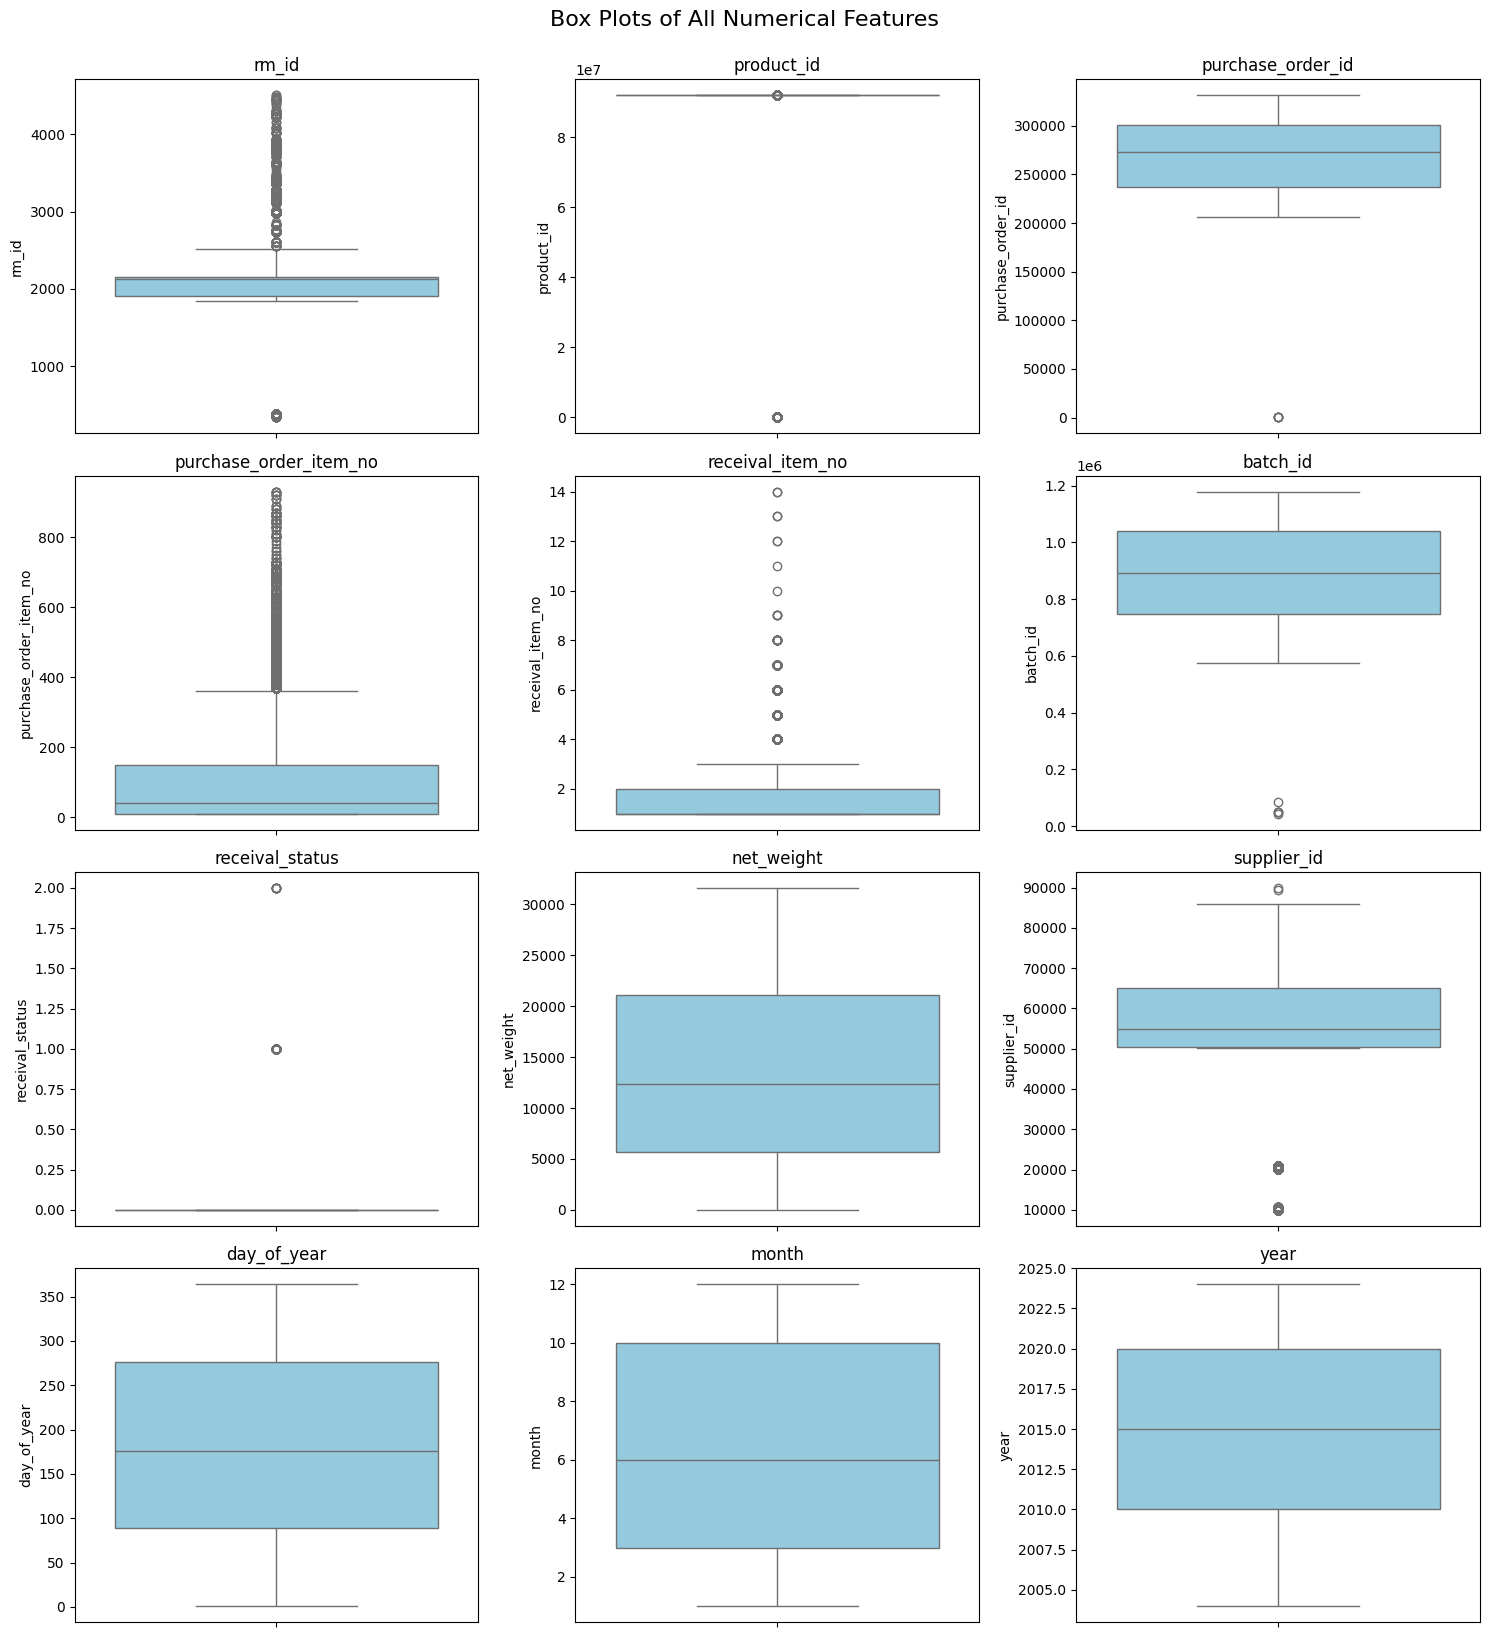

In [10]:
# Select numerical features
numeric_cols = df_receivals.select_dtypes(include='number').columns

# Grid size
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_receivals[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of All Numerical Features", fontsize=16, y=1.02)
plt.show()

#### Now we want to further analyze each of the rm_id as they might have patterns that are relevant.

In [11]:
## code that gives a list of all unique rm_ids
unique_rm_ids = df_receivals['rm_id'].unique() 

#### We look at the distribution of rm_id per year. Here we realized that some ids stopped being delivered around 2011, some were only received from around 2012-2015, while others only appear in the 2 last years. This was done by changing the rm_id in the first coding line. This then means that our future model will have to take year/time into account for further predictions.

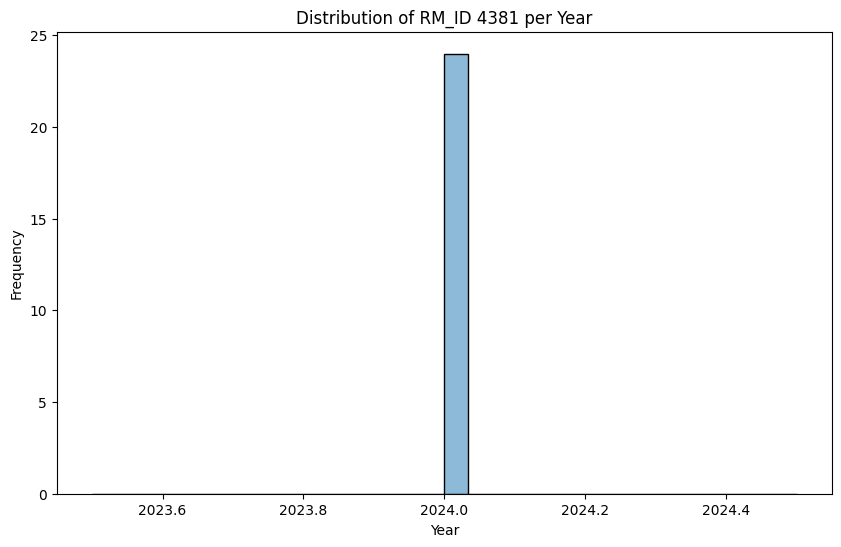

In [12]:
# distribution of rm_id 2197 per year
df_2197 = df_receivals[df_receivals['rm_id'] == 4222]
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df_2197, x='year', bins=30, kde=True)
plt.title('Distribution of RM_ID 4381 per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

#### At first, we thought that maybe only the rm_ids that had at least one appearance in 2024 would be necessary for prediction and then we would fill the rest with zeros. This ended up not being a good idea, as the training/validation error became much bigger than creating a model to predict for all the rm_ids and let this model learn the patterns.

In [ ]:
# FIND ALL THE UNIQUE RM_IDS THAT HAVE ROWS REGISTERED IN 2020 OR LATER
#unique_rm_ids_2024 = df_receivals[df_receivals['year'] >= 2024]['rm_id'].unique()

# REMOVE ALL ROWS THAT HAVE RM_IDS THAT AREN'T IN unique_rm_ids_2020
#df_receivals = df_receivals[df_receivals['rm_id'].isin(unique_rm_ids_2024)].reset_index(drop=True)

#### Here we made a count to see which rm_ids were more predominant and see if we should maybe model something after these.

In [15]:
# count of rm_id occurrences
rm_id_counts = df_receivals['rm_id'].value_counts().reset_index()
rm_id_counts.columns = ['rm_id', 'count']
print(rm_id_counts)

      rm_id  count
0    2130.0  23620
1    1903.0  19337
2    2160.0  13507
3    2140.0   5343
4    2142.0   4624
..      ...    ...
198  4343.0      1
199  4381.0      1
200  4461.0      1
201  4463.0      1
202  4462.0      1

[203 rows x 2 columns]


#### Since some of the rm_ids have very short counts, we want our future model to learn this pattern in some way, so we started by creating a simple probabilistic feature, dividing the count of that rm_id with all counts. We later realized that this didnt capture the full time essence, so it ended up not being used further and another probabilistic feature was required. We will get to this later on.

In [17]:
# Total number of rows (all purchases)
total_rows = len(df_receivals)

# Probability of purchase per RM_ID
rm_id_counts['purchase_prob'] = rm_id_counts['count'] / total_rows

# Merge this probability back into df_rec_purchase
df_receivals = df_receivals.merge(
    rm_id_counts[['rm_id', 'purchase_prob']],
    on='rm_id',
    how='left'
)


#### We wanted to evaluate whether any features worked as groups, meaning they were highly correlated.

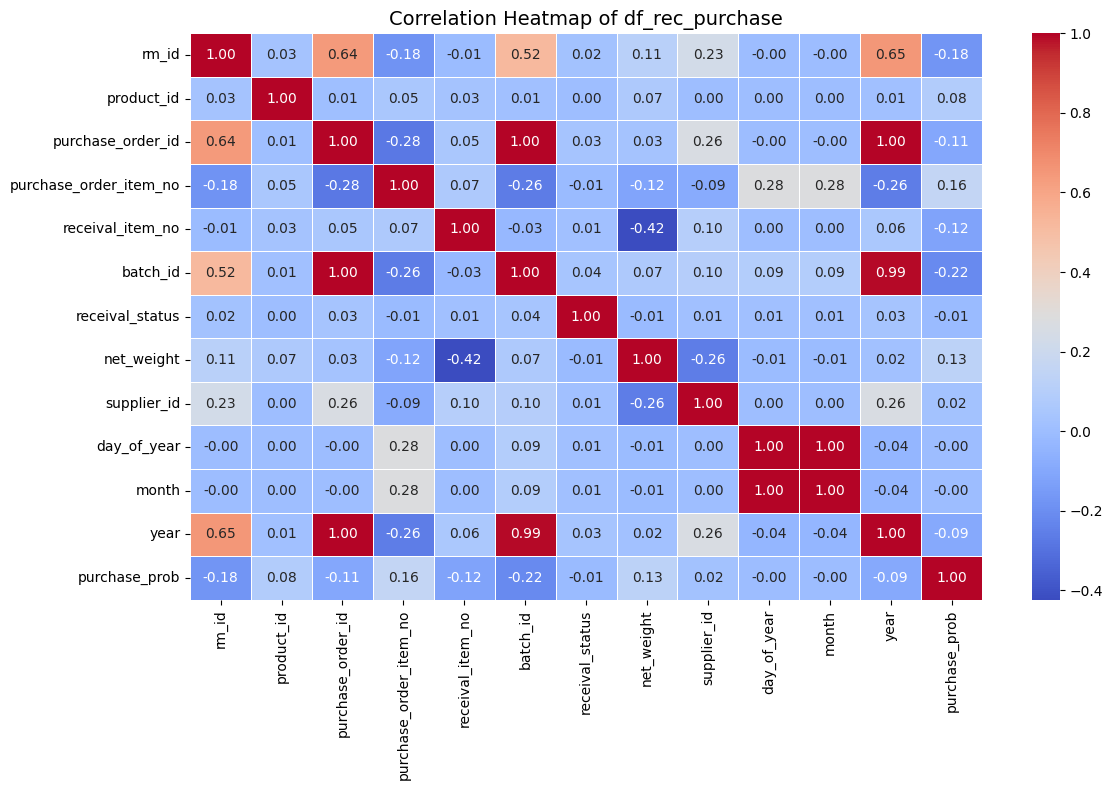

In [18]:
# Compute correlation matrix
corr = df_receivals.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap of df_rec_purchase", fontsize=14)
plt.tight_layout()
plt.show()

#### Here we save this just slightly clean dataset for further use.

In [19]:
# save to csv
#df_receivals.to_csv(r'C:\Users\bupat\OneDrive\Documentos\NTNU\modern_ml_in_practice\append_consulting_project\data\kernel\processed_receivals.csv', index=False)    

#### Merging with purchase_orders.csv

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### First, we need to extract the file. 

In [21]:
#df_receivals = pd.read_csv(r'C:\Users\bupat\OneDrive\Documentos\NTNU\modern_ml_in_practice\append_consulting_project\data\kernel\processed_receivals.csv')
df_purchase = pd.read_csv(r'purchase_orders.csv')

#### Get just some starting knowledge of which features, dtypes, amount of missing values, etc are in the purchase_orders.csv

In [22]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33171 entries, 0 to 33170
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_order_id       33171 non-null  int64  
 1   purchase_order_item_no  33171 non-null  int64  
 2   quantity                33171 non-null  float64
 3   delivery_date           33171 non-null  object 
 4   product_id              33171 non-null  int64  
 5   product_version         33171 non-null  int64  
 6   created_date_time       33171 non-null  object 
 7   modified_date_time      32679 non-null  object 
 8   unit_id                 33127 non-null  float64
 9   unit                    33127 non-null  object 
 10  status_id               33171 non-null  int64  
 11  status                  33171 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 3.0+ MB


#### Drop features that are non-intuitional, as we only need one date feature and we already have date_arrival and status as well, since status is just a categorical feature of status_id, so it is unncessary

In [23]:
# drop modified_date as it has too many NA values
df_purchase = df_purchase.drop(columns=['modified_date_time', 'status', 'created_date_time'])
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33171 entries, 0 to 33170
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_order_id       33171 non-null  int64  
 1   purchase_order_item_no  33171 non-null  int64  
 2   quantity                33171 non-null  float64
 3   delivery_date           33171 non-null  object 
 4   product_id              33171 non-null  int64  
 5   product_version         33171 non-null  int64  
 6   unit_id                 33127 non-null  float64
 7   unit                    33127 non-null  object 
 8   status_id               33171 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 2.3+ MB


#### Merge receivals and purchase_orders, using features that represent uniqueness and exist in both datasets. Purchase_order_id is quite non-intuitional for further predictions, but useful for merging, so it was used here and it will be removed in the future.

In [24]:
# Keys to merge on
key_cols = ['purchase_order_id', 'purchase_order_item_no', 'product_id']

# Convert df_receivals key columns to int64 to match df_purchase
for col in key_cols:
    df_receivals[col] = df_receivals[col].astype(int)
    df_purchase[col] = df_purchase[col].astype(int)

# Columns to bring from df_purchase
cols_to_merge = key_cols + ['quantity', 'delivery_date', 'product_version', 'unit_id', 'unit', 'status_id']

# Merge df_purchase onto df_receivals
df_receivals = df_receivals.merge(
    df_purchase[cols_to_merge],
    on=key_cols,
    how='left'
)

df_receivals.info()
df_copy = df_receivals.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122520 entries, 0 to 122519
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   rm_id                   122520 non-null  float64       
 1   product_id              122520 non-null  int64         
 2   purchase_order_id       122520 non-null  int64         
 3   purchase_order_item_no  122520 non-null  int64         
 4   receival_item_no        122520 non-null  int64         
 5   batch_id                64703 non-null   float64       
 6   date_arrival            122520 non-null  datetime64[ns]
 7   receival_status         122520 non-null  int8          
 8   net_weight              122520 non-null  float64       
 9   supplier_id             122520 non-null  int64         
 10  day_of_year             122520 non-null  int32         
 11  month                   122520 non-null  int32         
 12  year                    122520

#### We have to decide which date feature we need to use further, so we start by evaluating if date_arrival and delivery_date (expected delivery) are equal. They ended up not being equal for most cases, as we see from the print below, so then we only used date_arrival as it seemed to be the most useful, because it gives us exactly when the delivery arrives.

In [25]:
# Convert delivery_date to datetime, remove timezone, and keep only date
df_receivals['delivery_date'] = pd.to_datetime(
    df_receivals['delivery_date'], errors='coerce', utc=True
).dt.tz_convert(None).dt.date

# Convert date_arrival to datetime and take only date (if not already)
df_receivals['date_arrival'] = pd.to_datetime(
    df_receivals['date_arrival'], errors='coerce'
).dt.date

# Compare
df_receivals['delivery_equals_arrival'] = df_receivals['delivery_date'] == df_receivals['date_arrival']

# Check results
print(df_receivals[['delivery_date', 'date_arrival', 'delivery_equals_arrival']].head())
print(f"Number of matching dates: {df_receivals['delivery_equals_arrival'].sum()} / {len(df_receivals)}")

  delivery_date date_arrival  delivery_equals_arrival
0    2004-05-30   2004-06-23                    False
1    2006-12-30   2005-03-29                    False
2    2004-12-30   2004-09-01                    False
3    2004-12-30   2004-06-24                    False
4    2004-12-30   2004-06-30                    False
Number of matching dates: 4136 / 122520


#### So we do not use delivery_date.

In [26]:
# drop delivery_date
df_receivals = df_receivals.drop(columns=['delivery_date', 'delivery_equals_arrival'])
df_receivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122520 entries, 0 to 122519
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   rm_id                   122520 non-null  float64
 1   product_id              122520 non-null  int64  
 2   purchase_order_id       122520 non-null  int64  
 3   purchase_order_item_no  122520 non-null  int64  
 4   receival_item_no        122520 non-null  int64  
 5   batch_id                64703 non-null   float64
 6   date_arrival            122520 non-null  object 
 7   receival_status         122520 non-null  int8   
 8   net_weight              122520 non-null  float64
 9   supplier_id             122520 non-null  int64  
 10  day_of_year             122520 non-null  int32  
 11  month                   122520 non-null  int32  
 12  year                    122520 non-null  int32  
 13  purchase_prob           122520 non-null  float64
 14  quantity            

#### Now we have to handle NA values, so we start by getting some starting info tto understand what to do.

In [27]:
# Rows with any null values
null_rows = df_receivals[df_receivals.isnull().any(axis=1)]

# Show them
print(null_rows)

         rm_id  product_id  purchase_order_id  purchase_order_item_no  \
0        342.0    91900170             210274                      20   
1        343.0    91900143             212977                      10   
2        345.0    91900143             208537                      10   
3        346.0    91900146             208545                      20   
4        346.0    91900146             208532                      30   
...        ...         ...                ...                     ...   
122211  3883.0    91900471             321317                      30   
122388  3901.0    91901440             329980                      10   
122483  4401.0    91901370             327819                      10   
122484  4401.0    91901370             327819                      20   
122485  4401.0    91901370             327819                      30   

        receival_item_no   batch_id date_arrival  receival_status  net_weight  \
0                      1        NaN   2004

#### Before that we remove features unit and unit_id, as after merging there was only 1 unique value and it was Kg. Unnecessary and just informational features, with no predictive interest so we just drop these two features. 

In [28]:
# DROP UNIT AND UNIT_ID AS THEY ALL JUST SHOW KG ANYWAYS
df_receivals = df_receivals.drop(columns=['unit', 'unit_id'])
df_receivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122520 entries, 0 to 122519
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   rm_id                   122520 non-null  float64
 1   product_id              122520 non-null  int64  
 2   purchase_order_id       122520 non-null  int64  
 3   purchase_order_item_no  122520 non-null  int64  
 4   receival_item_no        122520 non-null  int64  
 5   batch_id                64703 non-null   float64
 6   date_arrival            122520 non-null  object 
 7   receival_status         122520 non-null  int8   
 8   net_weight              122520 non-null  float64
 9   supplier_id             122520 non-null  int64  
 10  day_of_year             122520 non-null  int32  
 11  month                   122520 non-null  int32  
 12  year                    122520 non-null  int32  
 13  purchase_prob           122520 non-null  float64
 14  quantity            

#### Now we have to evaluate what to do with missing NA values. As we see from above, batch_id is the main source for the NA values, and it is also a non-intuitional feature for predictions, however it is necessary to have it if we want to merge with both the materials and transport datasets. So first, we thought of using MICE as you see below. Then these would fill for the batch_id, which we would remove later, and then for both quantity and product version and id, which we think could be useful and informative for the future. However there were not a lot of NA rows for those features, so we decided it would be faster and more accurate to just predict on the values we actually have.

In [29]:
#from sklearn.experimental import enable_iterative_imputer  # noqa: F401
#from sklearn.impute import IterativeImputer
#import numpy as np

# Define and apply the imputer
#imputer = IterativeImputer(random_state=0)
#imputed_data = imputer.fit_transform(df_receivals[['quantity', 'product_version', 'status_id']])

# Assign imputed values back
#df_receivals[['quantity', 'product_version', 'status_id']] = imputed_data

# Round all three columns to nearest whole number but keep as float
#cols_to_round = ['quantity', 'product_version', 'status_id']
#df_receivals[cols_to_round] = np.round(df_receivals[cols_to_round], 0).astype(float)

# Check result
#df_receivals.info()

#### So then, we drop all rows that have NA values.

In [30]:
# DROP ROWS WITH NA VALUES
df_receivals = df_receivals.dropna()
df_receivals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64167 entries, 20 to 122519
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   rm_id                   64167 non-null  float64
 1   product_id              64167 non-null  int64  
 2   purchase_order_id       64167 non-null  int64  
 3   purchase_order_item_no  64167 non-null  int64  
 4   receival_item_no        64167 non-null  int64  
 5   batch_id                64167 non-null  float64
 6   date_arrival            64167 non-null  object 
 7   receival_status         64167 non-null  int8   
 8   net_weight              64167 non-null  float64
 9   supplier_id             64167 non-null  int64  
 10  day_of_year             64167 non-null  int32  
 11  month                   64167 non-null  int32  
 12  year                    64167 non-null  int32  
 13  purchase_prob           64167 non-null  float64
 14  quantity                64167 non-null  f

#### Another Box-Plot to evaluate the individual distributions of each feature, especially if we need to look into outliers.

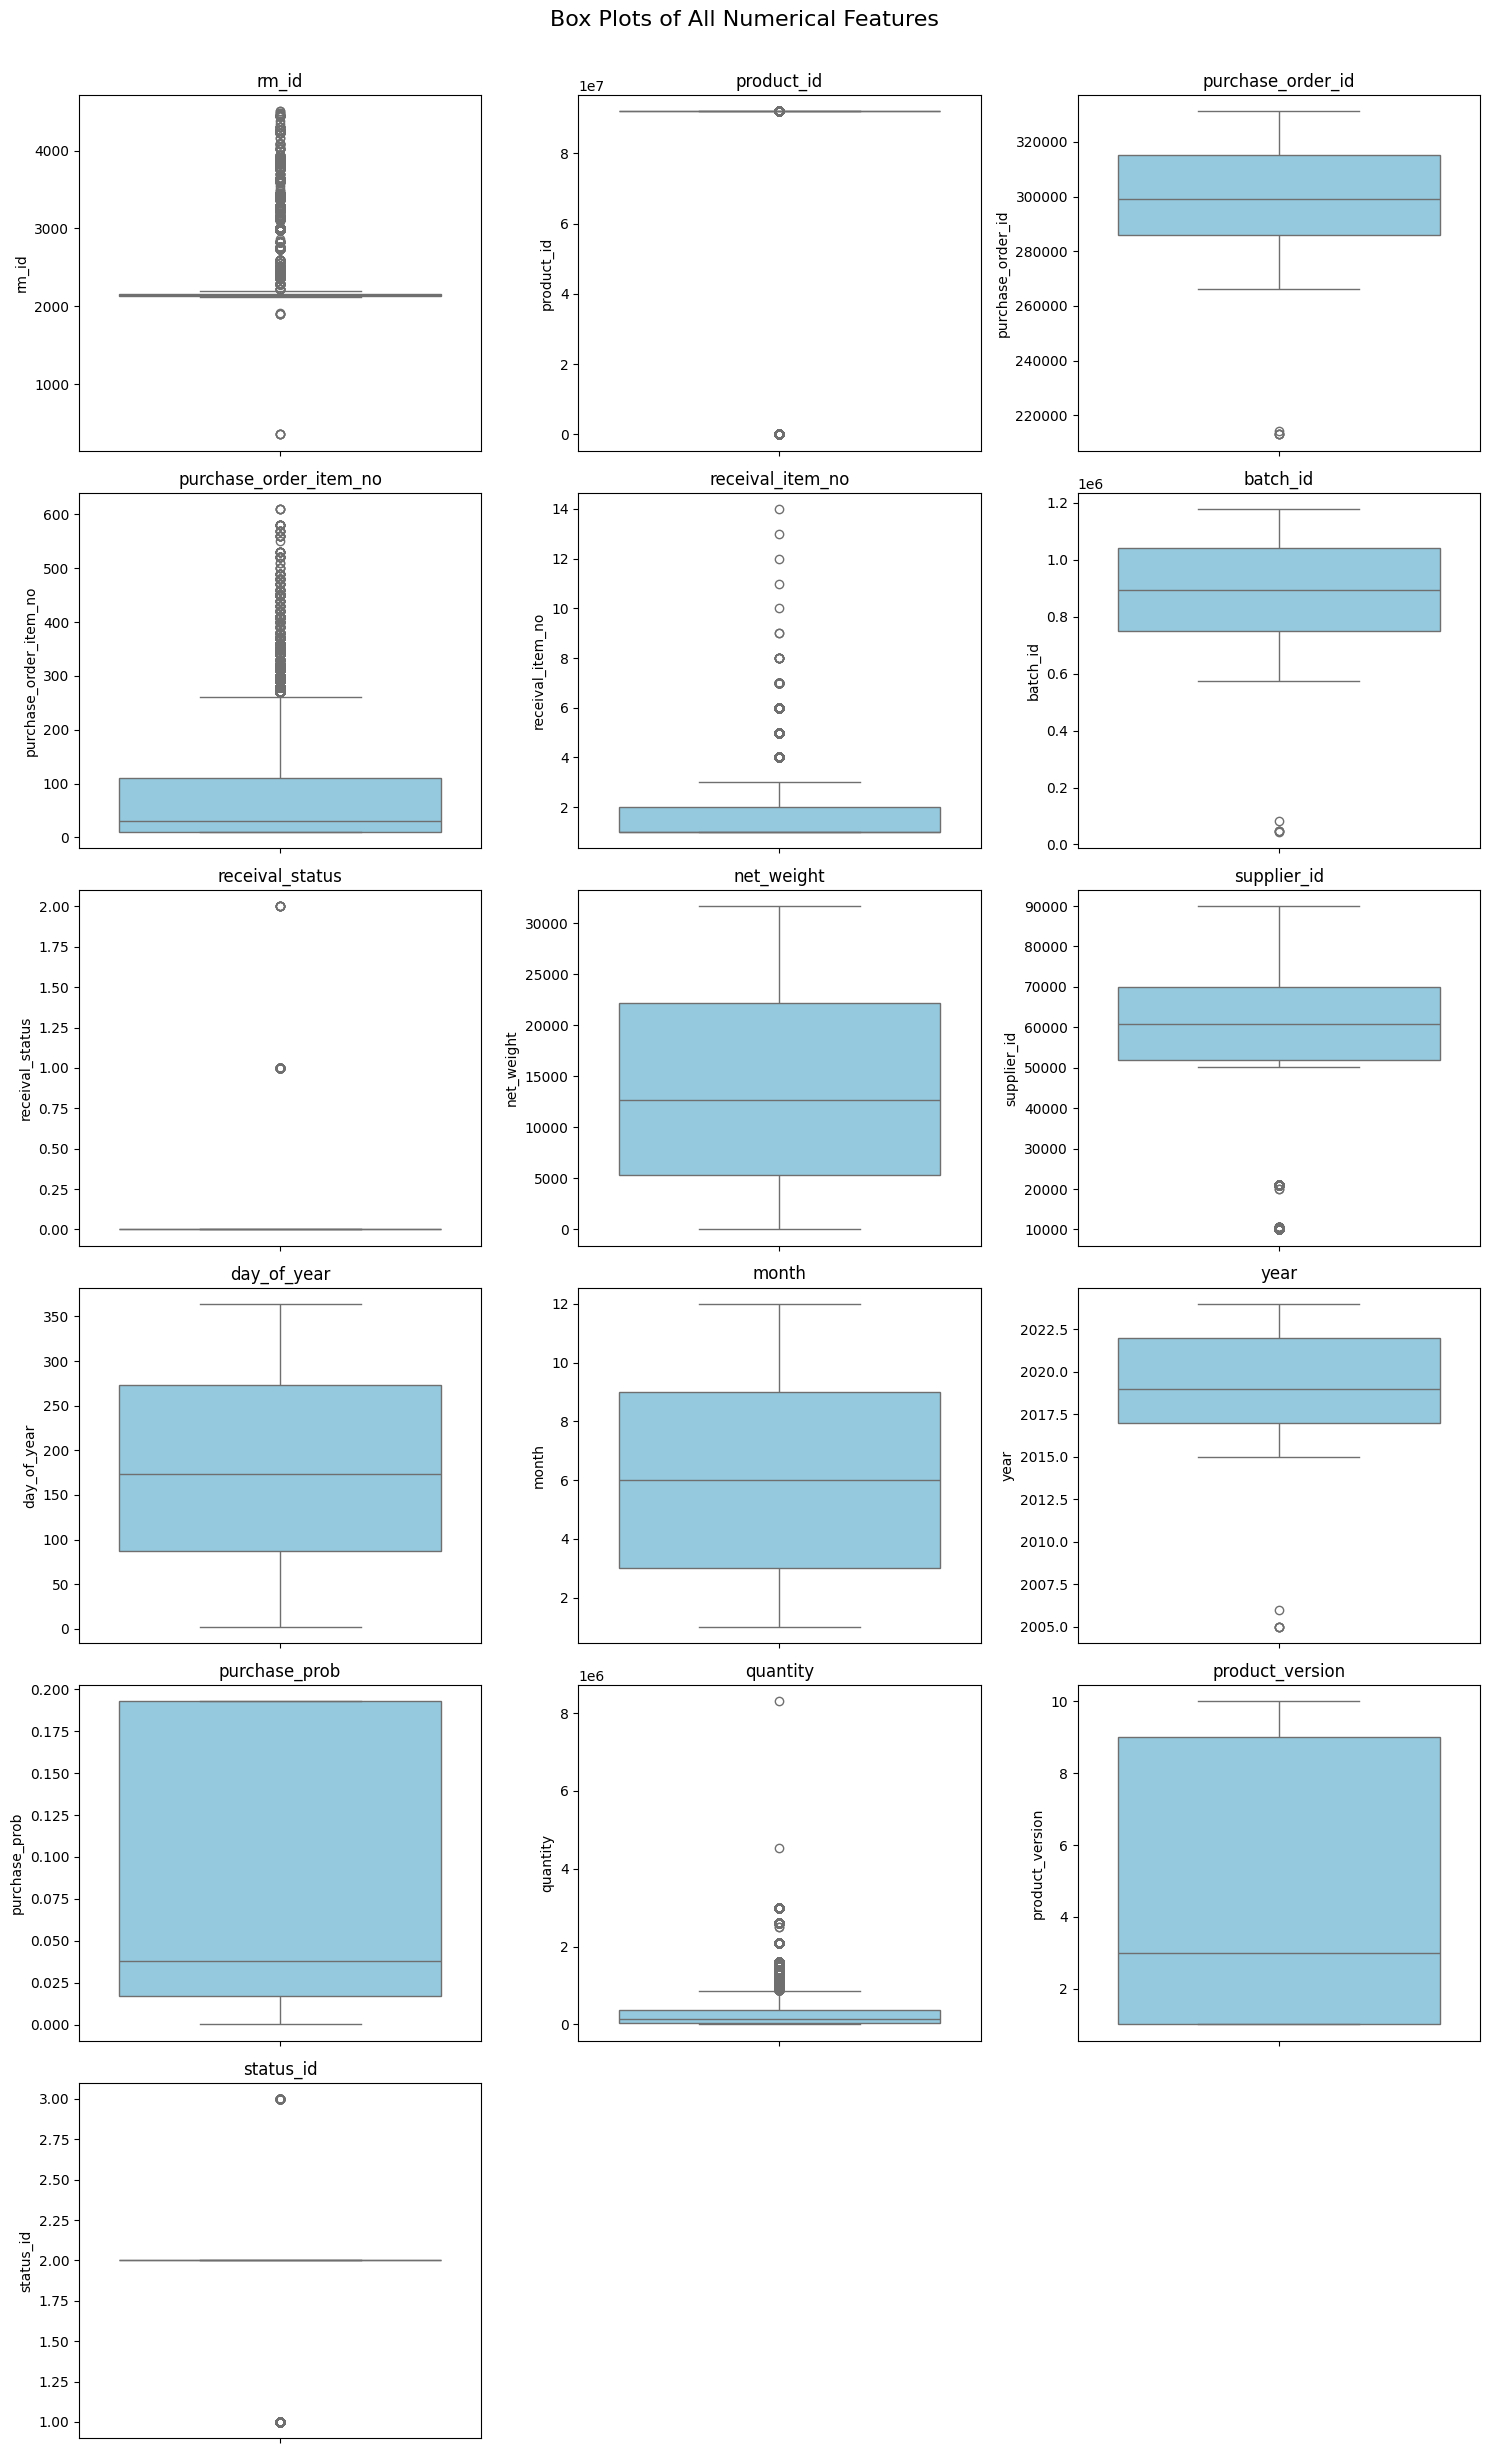

In [31]:
# Select numerical features
numeric_cols = df_receivals.select_dtypes(include='number').columns

# Grid size
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_receivals[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of All Numerical Features", fontsize=16, y=1.02)
plt.show()

#### Now we have more features, so we want to evaluate whether there are any groupings or high correlations again.

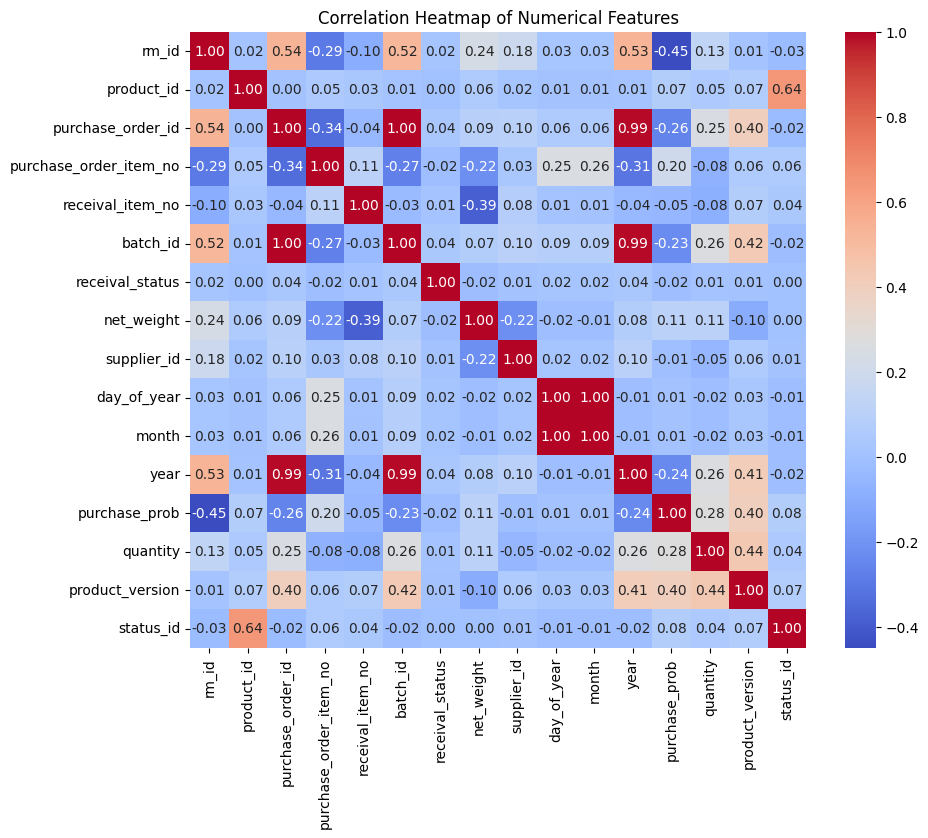

In [32]:
# correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = df_receivals[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


#### Now we create a copied dataset in case we need to use just the receivals and purchase_orders together, without materials and transport.

In [33]:
df_copy.drop(columns=['batch_id', 'unit', 'unit_id', 'purchase_order_id', 'purchase_order_item_no', 'delivery_date'], inplace=True)
df_copy.dropna(inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118580 entries, 0 to 122519
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   rm_id             118580 non-null  float64       
 1   product_id        118580 non-null  int64         
 2   receival_item_no  118580 non-null  int64         
 3   date_arrival      118580 non-null  datetime64[ns]
 4   receival_status   118580 non-null  int8          
 5   net_weight        118580 non-null  float64       
 6   supplier_id       118580 non-null  int64         
 7   day_of_year       118580 non-null  int32         
 8   month             118580 non-null  int32         
 9   year              118580 non-null  int32         
 10  purchase_prob     118580 non-null  float64       
 11  quantity          118580 non-null  float64       
 12  product_version   118580 non-null  float64       
 13  status_id         118580 non-null  float64       
dtypes: dateti

#### During this project, we actually used multiple files, so saving datasets was a normal procedure for us. 

In [34]:
# SAVE TO CSV
#df_receivals.to_csv(r'C:\Users\bupat\OneDrive\Documentos\NTNU\modern_ml_in_practice\append_consulting_project\data\kernel\purchase_receivals.csv')
#df_copy.to_csv(r'C:\Users\bupat\OneDrive\Documentos\NTNU\modern_ml_in_practice\append_consulting_project\data\kernel\copy_purchase_receivals.csv')

## FEATURE ENGINEERING (JUST SLIGHTLY MORE DATA CLEANING AS WELL)

In [35]:
# ============================================================
# 0. Imports & Setup
# ============================================================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform
from sklearn.inspection import PartialDependenceDisplay

#### Here we extract the prediction mapping file and evaluate how we want our future model to look. We quickly realize we only have the dates and rm_ids available for 2025, so using features that aren't time or rm_id based will need to be implemented in some way. This will be shown just a few cells below.

#### Also, we would like to mention that we also tried to use materials and transport, however because of batch_id being the glue feature with materials and transport, we lost more than half of the rows in the data and it would not give accurate models. So we decide to use just receivals and purchase_orders as our source for predictions.

In [36]:
prediction_mapping = pd.read_csv("prediction_mapping.csv")
df_rec_purchase = df_copy

print("Files loaded successfully!")
print("\n--- prediction_mapping ---")
print(prediction_mapping.head())

print("\n--- df_rec_purchase ---")
print(df_rec_purchase.head())

Files loaded successfully!

--- prediction_mapping ---
   ID  rm_id forecast_start_date forecast_end_date
0   1    365          2025-01-01        2025-01-02
1   2    365          2025-01-01        2025-01-03
2   3    365          2025-01-01        2025-01-04
3   4    365          2025-01-01        2025-01-05
4   5    365          2025-01-01        2025-01-06

--- df_rec_purchase ---
   rm_id  product_id  receival_item_no date_arrival  receival_status  \
0  342.0    91900170                 1   2004-06-23                0   
1  343.0    91900143                 1   2005-03-29                0   
2  345.0    91900143                 1   2004-09-01                0   
3  346.0    91900146                 3   2004-06-24                0   
4  346.0    91900146                 1   2004-06-30                0   

   net_weight  supplier_id  day_of_year  month  year  purchase_prob  \
0     24940.0        52433          175      6  2004       0.000008   
1     21760.0        54748           88

#### Before we start looking to add features, we first had to clean the dataset just a bit further as both status_id and receival_status seemed quite non-intuitional (just out of pure logic) in order to predict the weight of receivals.

In [37]:
# DROP UNIT_STATUS, STATUS_ID AND RECEIVAL_STATUS AS THESE ARE MAINLY JUST ONE VALUE AND HAVE VERY LITTLE CORRELATION TO TARGET VALUE
df_rec_purchase = df_rec_purchase.drop(columns=[#'unit_status', 
                                                'status_id', 
                                                'receival_status']) 

#### At this point, we realized that there were multiple registers of arrivals in the same days, so multiple rows had the same date and rm_ids. So here we needed to do something with it and need to put all those rows into just one data to make it easier for our model to pick up possible daily trends. So we sum features with quantitative features, such as quantity or net_weight, averaged product_version and receival_item_no, realized product_id was equal to rm_id for every row and then calculated the amount of unique suppliers that were delivering arrivals that day. The features that were commented were features to be used in case we decided to use features from materials and transport for our model.

In [38]:
# Define aggregation dictionary
agg_dict = {
    # Summed numeric totals
    'net_weight': 'sum',
    #'tare_weight': 'sum',
    #'gross_weight': 'sum',
    'quantity': 'sum',
    #'impurity_deduction_weight': 'sum',

    # Averages
    #'vehicle_start_weight': 'mean',
    #'vehicle_end_weight': 'mean',
    'product_version': 'mean',
    'receival_item_no': 'mean',

    # Categorical / ID handling
    'product_id': 'first',
    'supplier_id': 'nunique',
    #'vehicle_no': 'nunique',

    # Keep this as reference (likely constant)
    #'purchase_prob': 'first'
}

# Perform daily aggregation per rm_id
df_daily = (
    df_rec_purchase.groupby(['rm_id', 'year', 'day_of_year', 'month', 'date_arrival'], as_index=False)
      .agg(agg_dict)
)

df_rec_purchase = df_daily.copy()

print(" Aggregated dataset shape:", df_daily.shape)
print(df_daily.head())


 Aggregated dataset shape: (40705, 11)
   rm_id  year  day_of_year  month date_arrival  net_weight   quantity  \
0  342.0  2004          175      6   2004-06-23     24940.0    52000.0   
1  343.0  2005           88      3   2005-03-29     21760.0  4530000.0   
2  345.0  2004          245      9   2004-09-01     22780.0  6575000.0   
3  346.0  2004          176      6   2004-06-24       820.0   335550.0   
4  346.0  2004          182      6   2004-06-30     21260.0   600000.0   

   product_version  receival_item_no  product_id  supplier_id  
0              1.0               1.0    91900170            1  
1              1.0               1.0    91900143            1  
2              1.0               1.0    91900143            1  
3              1.0               3.0    91900146            1  
4              1.0               1.0    91900146            1  


#### Now we had to decide between 2 things: Either predict for net_weight and then remove the rows which weren't possible to predict for in 2025, because they stopped being delivered, or predict using the cumulative weight and let our model understand the trends by itself by training. We tried both and concluded at the end that our model would be much more accurate if we predict for the cumulative weight. So here, to understand the full trends that are happening, we need to fill our dataset with possible dates, from the first available to last available dates and fill all values with 0, as if they were not in the dataset, then no deliveries were made, or they had NA values that were removed before. 

In [39]:
import pandas as pd
import numpy as np

# ============================================================
#  Ensure date_arrival is datetime
# ============================================================
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

# ============================================================
#  Prepare date range and RM_ID list
# ============================================================
min_date = df_rec_purchase['date_arrival'].min()
max_date = df_rec_purchase['date_arrival'].max()

print(f" Expanding dates from {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
all_rm_ids = df_rec_purchase['rm_id'].unique()

# ============================================================
# Create full RM_ID × date grid
# ============================================================
full_index = pd.MultiIndex.from_product(
    [all_rm_ids, all_dates],
    names=['rm_id', 'date_arrival']
)
full_df = pd.DataFrame(index=full_index).reset_index()

# ============================================================
# Merge original dataset onto full grid
# ============================================================
df_expanded = full_df.merge(df_rec_purchase, on=['rm_id', 'date_arrival'], how='left')

# ============================================================
# Fill derived date parts
# ============================================================
df_expanded['year'] = df_expanded['date_arrival'].dt.year
df_expanded['month'] = df_expanded['date_arrival'].dt.month
df_expanded['day_of_year'] = df_expanded['date_arrival'].dt.dayofyear

# ============================================================
# Fill missing numeric features with 0
# ============================================================
numeric_cols = df_rec_purchase.select_dtypes(include=[np.number]).columns.tolist()
df_expanded[numeric_cols] = df_expanded[numeric_cols].fillna(0)

# ============================================================
#  Sort and finalize
# ============================================================
df_expanded = df_expanded.sort_values(['rm_id', 'date_arrival']).reset_index(drop=True)
df_rec_purchase = df_expanded.copy()

print(" Expanded dataset created successfully!")
print(f"Shape: {df_rec_purchase.shape}")
print(df_rec_purchase.head())


 Expanding dates from 2004-06-15 to 2024-12-19
 Expanded dataset created successfully!
Shape: (1423670, 11)
   rm_id date_arrival  year  day_of_year  month  net_weight  quantity  \
0  342.0   2004-06-15  2004          167      6         0.0       0.0   
1  342.0   2004-06-16  2004          168      6         0.0       0.0   
2  342.0   2004-06-17  2004          169      6         0.0       0.0   
3  342.0   2004-06-18  2004          170      6         0.0       0.0   
4  342.0   2004-06-19  2004          171      6         0.0       0.0   

   product_version  receival_item_no  product_id  supplier_id  
0              0.0               0.0         0.0          0.0  
1              0.0               0.0         0.0          0.0  
2              0.0               0.0         0.0          0.0  
3              0.0               0.0         0.0          0.0  
4              0.0               0.0         0.0          0.0  


#### So here we create the cumulative weight feature, which becomes our target feature.

In [40]:
# create feature cum_weight_per_year for each of the rm_id per year until that day_of_year, counting the net_weight of that day_of_year
df_rec_purchase['cum_weight_per_year'] = df_rec_purchase.groupby(['rm_id', 'year'])['net_weight'].cumsum()

#### Re-evaluate if we need to take outliers into account after all these changes, by looking at the individual feature distributions.

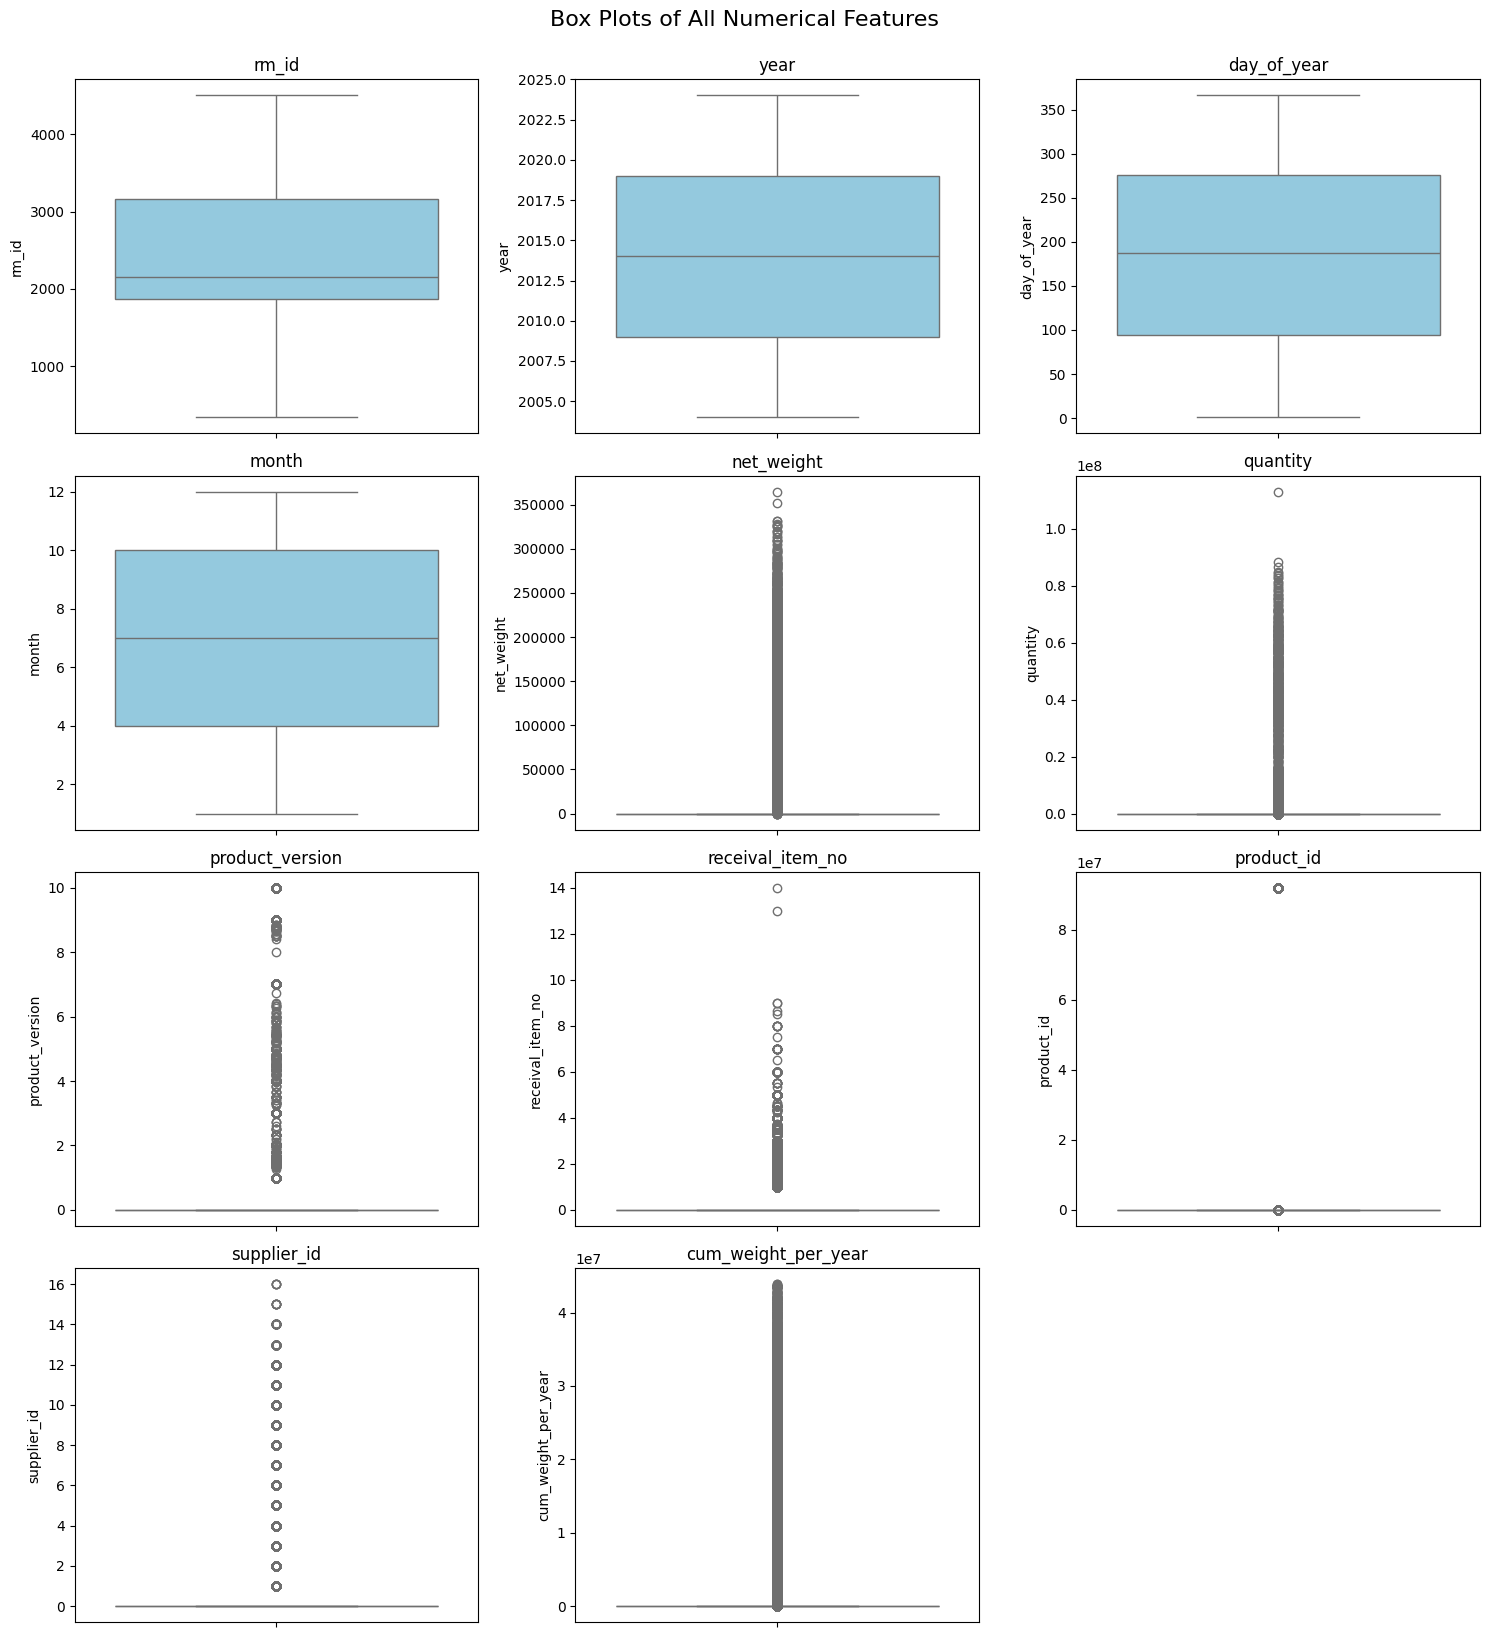

In [41]:
# Select numerical features
numeric_cols = df_rec_purchase.select_dtypes(include='number').columns

# Grid size
n_cols = 3  # number of plots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_rec_purchase[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Box Plots of All Numerical Features", fontsize=16, y=1.02)
plt.show()

#### Now we plot just to evaluate how much the net_weight changes per month from other years compared to 2024, to see if our hypothesis that 2023 and 2024 might be more relevant for 2025. We end up further agreeing with the hypothesis as for most of the rm_ids the values of 2023 and 2024 were quite close and below the net_weight values from the years before, meaning there has been a decrease in the amount bought these last 2 years.

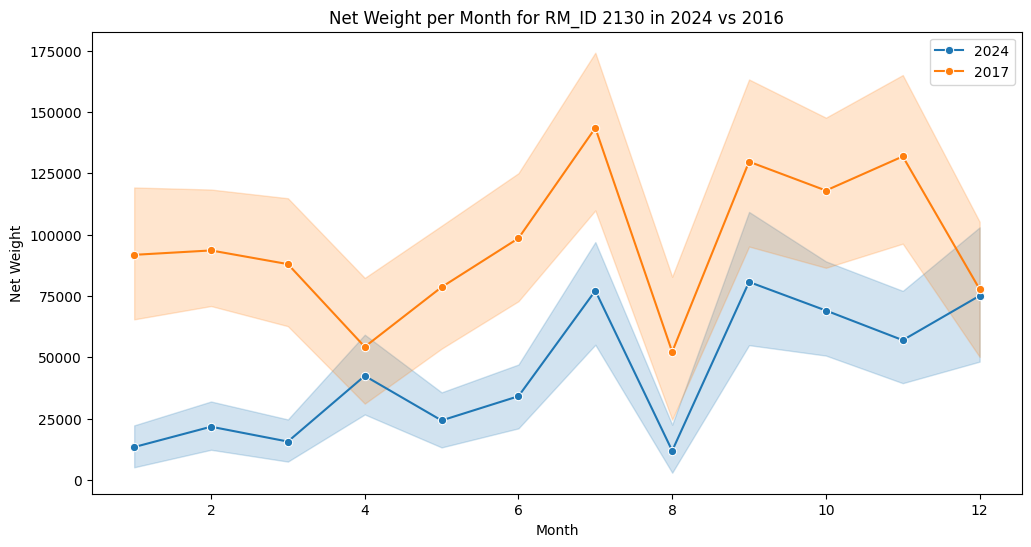

In [43]:
# PLOT NET_WEIGHT PER MONTH FOR YEARS 2024 AND 2016 FOR RM_ID = 2130 TO COMPARE
df_2130_2024 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2130) & (df_rec_purchase['year'] == 2024)]
df_2130_2016 = df_rec_purchase[(df_rec_purchase['rm_id'] == 2130) & (df_rec_purchase['year'] == 2020)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2130_2024, x='month', y='net_weight', label='2024', marker='o')
sns.lineplot(data=df_2130_2016, x='month', y='net_weight', label='2017', marker='o')
plt.title('Net Weight per Month for RM_ID 2130 in 2024 vs 2016')
plt.xlabel('Month')
plt.ylabel('Net Weight')
plt.legend()
plt.show()

#### Here we looked at the possibility of removing days that were too big in order to smoothen our dataset values, however removing weight outliers did not make sense as we wanted our future model to understand the decreasing patterns for the 2 last years.

In [44]:
# REMOVE OUTLIERS BY REMOVING ROWS WITH NET_WEIGHT > 200000
#df_rec_purchase = df_rec_purchase[df_rec_purchase['net_weight'] <= 200000]

#### We evaluate the correlation again, to see if the dataset change has caused any new groups or correlations.

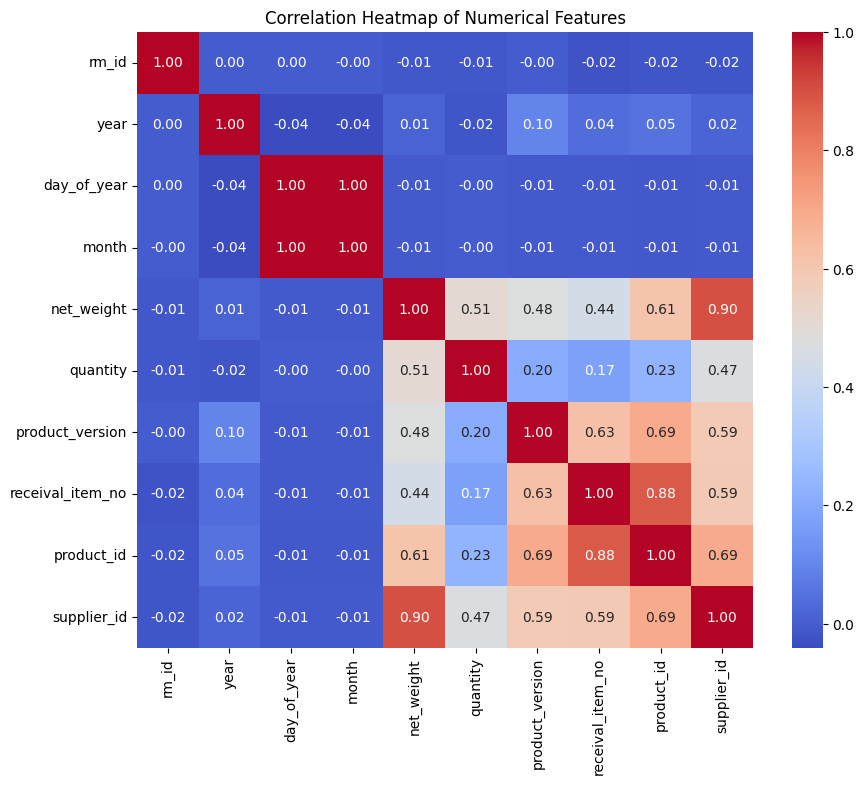

In [45]:
# correlation heatmap for numerical features
numeric_cols = [col for col in df_daily.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_rec_purchase[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

#### We also played with the possibility of removing very rare rm_id, those who only appeared once in a period of 20 years, however that is exactly what we want our model to learn by training so we ended up not using this.

In [46]:
# REMOVE ROWS THAT HAVE RM_IDS WITH A COUNT OF 1
#rm_id_counts = df_rec_purchase['rm_id'].value_counts()
#df_rec_purchase = df_rec_purchase[df_rec_purchase['rm_id'].isin(rm_id_counts[rm_id_counts > 1].index)]
#print(" Dataset shape after removing rm_ids with single entries:", df_rec_purchase.shape)

#### We also discovered that there were absolutely no receivals on weekends, which means this would cause a discrepancy using day_of_year as some day of the year could in a weekend one year and not on another. So to get more into detail, we decided to use the combination of week of year and day of week.

In [47]:
# Ensure date_arrival is datetime
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

# Extract week of year and day of week
df_rec_purchase['week_of_year'] = df_rec_purchase['date_arrival'].dt.isocalendar().week.astype(int)
df_rec_purchase['day_of_week'] = df_rec_purchase['date_arrival'].dt.weekday  # Monday=0, Sunday=6

#### Here we started to think about the problem of the prediction mapping and the features we were going to use. So we tried using averages for all of the years, for the features used for predictions, however these were too general and did not get the trends for those features, so we decided to apply a "rolling" but static average of 2 years prior (for no leakage) to that, mainly because data from 2023 and 2024 were related and it would be useful for 2025 predictions. We average, for each feature, on the same rm_id, week_of_year and day_of_week combination. This way the model could get trends and understand how these were moving through time.

In [48]:
import pandas as pd

# ============================================================
# Setup
# ============================================================
exclude_cols = ['rm_id', 'day_of_year', 'year', 'month', 'cum_weight_per_year']
numeric_cols = [c for c in df_rec_purchase.select_dtypes(include='number').columns if c not in exclude_cols + ['week_of_year', 'day_of_week']]

# Compute yearly means
yearly_avg = (
    df_rec_purchase
    .groupby(['rm_id', 'week_of_year', 'day_of_week', 'year'])[numeric_cols]
    .mean()
    .reset_index()
)

# ============================================================
# Self-merge to bring in previous two years
# ============================================================
# Shift year by -1 (previous year) and -2 (two years before)
lag1 = yearly_avg.copy()
lag1['year'] += 1
lag1 = lag1.rename(columns={col: f'prev1_{col}' for col in numeric_cols})

lag2 = yearly_avg.copy()
lag2['year'] += 2
lag2 = lag2.rename(columns={col: f'prev2_{col}' for col in numeric_cols})

# Merge both lag datasets
merged = yearly_avg.merge(lag1, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')
merged = merged.merge(lag2, on=['rm_id', 'week_of_year', 'day_of_week', 'year'], how='left')

# ============================================================
# Compute strict 2-year average
# ============================================================
for col in numeric_cols:
    merged[f'avg_{col}'] = merged[[f'prev1_{col}', f'prev2_{col}']].mean(axis=1)

# ============================================================
# Merge back to main df
# ============================================================
avg_cols = [f'avg_{c}' for c in numeric_cols]
df_rec_purchase = df_rec_purchase.merge(
    merged[['rm_id', 'week_of_year', 'day_of_week', 'year'] + avg_cols],
    on=['rm_id', 'week_of_year', 'day_of_week', 'year'],
    how='left'
)

print(" Strict 2-year average features created")
print(f"Shape: {df_rec_purchase.shape}")
print(df_rec_purchase.head())

 Strict 2-year average features created
Shape: (1423670, 20)
   rm_id date_arrival  year  day_of_year  month  net_weight  quantity  \
0  342.0   2004-06-15  2004          167      6         0.0       0.0   
1  342.0   2004-06-16  2004          168      6         0.0       0.0   
2  342.0   2004-06-17  2004          169      6         0.0       0.0   
3  342.0   2004-06-18  2004          170      6         0.0       0.0   
4  342.0   2004-06-19  2004          171      6         0.0       0.0   

   product_version  receival_item_no  product_id  supplier_id  \
0              0.0               0.0         0.0          0.0   
1              0.0               0.0         0.0          0.0   
2              0.0               0.0         0.0          0.0   
3              0.0               0.0         0.0          0.0   
4              0.0               0.0         0.0          0.0   

   cum_weight_per_year  week_of_year  day_of_week  avg_net_weight  \
0                  0.0            25    

#### Then we also thought lag features of the cumulative weight per year, could be useful so the model understands how the weight was moving the year before. Not only that we wanted to make our model understand how it was moving within the same year, so we calculated the lag 1 feature (1 day before), lag7 (one week before) and a lag 30 feature. Now this causes a prediction problem because if we are going to use these values, we first of all need a method that handles NA values and takes them as info (LightGBM, CatBoost, etc.) and we need to use the lag values from the year prior to our current year, so we avoid doing recursive predictions, which takes quite a lot of time. So we use the lag features from the year before, for the same combination of rm_id, week of the year and day of the week. In addition, for the same combination of time, create a feature that gives us the exact cumulative weight for that rm_id on that same day, the year before.

In [49]:
import pandas as pd

# ============================================================
# Ensure proper ordering
# ============================================================
df_rec_purchase = df_rec_purchase.sort_values(['rm_id', 'date_arrival']).reset_index(drop=True)

# ============================================================
# Compute lag features (1, 7, 30 days) within each rm_id
# ============================================================
lag_features = df_rec_purchase[['rm_id', 'year', 'week_of_year', 'day_of_week', 'cum_weight_per_year']].copy()

# Sort by rm_id and temporal order
lag_features = lag_features.sort_values(['rm_id', 'year', 'week_of_year', 'day_of_week'])

# Compute lags inside each rm_id
lag_features['lag1_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(1)
lag_features['lag7_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(7)
lag_features['lag30_cum_weight_per_year'] = lag_features.groupby('rm_id')['cum_weight_per_year'].shift(30)

# ============================================================
# Create next-year alignment (shift forward one year)
# ============================================================
# Increment year to align previous-year lags with current-year rows
lag_features['year'] = lag_features['year'] + 1

# Rename columns to indicate they're from the previous year
lag_features = lag_features.rename(columns={
    'cum_weight_per_year': 'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year': 'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year': 'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year': 'lag30_cum_weight_per_year_prev_year'
})

# Keep only needed columns
lag_features = lag_features[[
    'rm_id', 'year', 'week_of_year', 'day_of_week',
    'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year_prev_year'
]]

# ============================================================
# Merge all prev-year features into the main dataframe
# ============================================================
df_rec_purchase = df_rec_purchase.merge(
    lag_features,
    on=['rm_id', 'year', 'week_of_year', 'day_of_week'],
    how='left'
)

# ============================================================
# (Optional) Drop old roll2yr feature if it exists
# ============================================================
if 'roll2yr_cum_weight_per_year' in df_rec_purchase.columns:
    df_rec_purchase = df_rec_purchase.drop(columns=['roll2yr_cum_weight_per_year'])
    print("Dropped old roll2yr_cum_weight_per_year column.")

# ============================================================
# Quick check
# ============================================================
cols_show = [
    'rm_id', 'date_arrival', 'year', 'week_of_year', 'day_of_week',
    'cum_weight_per_year',
    'cum_weight_per_year_prev_year',
    'lag1_cum_weight_per_year_prev_year',
    'lag7_cum_weight_per_year_prev_year',
    'lag30_cum_weight_per_year_prev_year'
]

print(" Created cum_weight_per_year_prev_year + lag1, lag7, lag30 previous-year features.")
print(df_rec_purchase[cols_show].head(20))

 Created cum_weight_per_year_prev_year + lag1, lag7, lag30 previous-year features.
    rm_id date_arrival  year  week_of_year  day_of_week  cum_weight_per_year  \
0   342.0   2004-06-15  2004            25            1                  0.0   
1   342.0   2004-06-16  2004            25            2                  0.0   
2   342.0   2004-06-17  2004            25            3                  0.0   
3   342.0   2004-06-18  2004            25            4                  0.0   
4   342.0   2004-06-19  2004            25            5                  0.0   
5   342.0   2004-06-20  2004            25            6                  0.0   
6   342.0   2004-06-21  2004            26            0                  0.0   
7   342.0   2004-06-22  2004            26            1                  0.0   
8   342.0   2004-06-23  2004            26            2              24940.0   
9   342.0   2004-06-24  2004            26            3              24940.0   
10  342.0   2004-06-25  2004         

#### Further, our model needs even more information to understand the either decreasing or increasing patterns of the cumulative weight at all times. So we create a 3 months prior purchase probability feature, which gives us the amount of days with purchases divided by the total amount of days for the 3 months prior to the current month. That will be quite useful as it will work as a carry-over from the 3 last months of 2024 into 2025 for our predictions. Note: We only use the 3 last months probabilities of purchase for the prediction of the 6 months of 2025, so we avoid the increase of run time by predicting recursively.

In [50]:
# Copy main dataset
df = df_rec_purchase.copy()
df['date_arrival'] = pd.to_datetime(df['date_arrival'], errors='coerce')
df['year'] = df['date_arrival'].dt.year
df['month'] = df['date_arrival'].dt.month

# Purchase flag (1 if any purchase, else 0)
df['purchase_flag'] = (df['net_weight'] > 0).astype(int)

# --------------------------------------------------------
# Monthly purchase probability per RM_ID
# --------------------------------------------------------
monthly_prob = (
    df.groupby(['rm_id', 'year', 'month'], as_index=False)
      .agg(
          total_days=('date_arrival', 'nunique'),
          days_with_purchase=('purchase_flag', 'sum')
      )
)
monthly_prob['purchase_prob'] = monthly_prob['days_with_purchase'] / monthly_prob['total_days']

# Month start for sorting & rolling
monthly_prob['month_start'] = pd.to_datetime(
    monthly_prob['year'].astype(str) + '-' + monthly_prob['month'].astype(str) + '-01'
)
monthly_prob = monthly_prob.sort_values(['rm_id', 'month_start'])

# --------------------------------------------------------
# Rolling 3-month mean of purchase_prob (previous months only)
# --------------------------------------------------------
monthly_prob['prev_purchase_prob'] = (
    monthly_prob.groupby('rm_id')['purchase_prob']
    .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).mean())
    .reset_index(level=0, drop=True)
)

# --------------------------------------------------------
# Drop early-year rows with NA (not enough 3-month history)
# --------------------------------------------------------
first_year = monthly_prob['year'].min()
monthly_prob.loc[monthly_prob['year'] == first_year, 'prev_purchase_prob'] = np.nan
monthly_prob = monthly_prob.dropna(subset=['prev_purchase_prob'])

# --------------------------------------------------------
# Merge back to main df
# --------------------------------------------------------
df = df.merge(
    monthly_prob[['rm_id', 'year', 'month', 'prev_purchase_prob',
                  'days_with_purchase', 'total_days']],
    on=['rm_id', 'year', 'month'],
    how='left'
)

# --------------------------------------------------------
# Cleanup
# --------------------------------------------------------
df = df.drop(columns=['purchase_flag'])
df_rec_purchase = df

# --------------------------------------------------------
# Preview
# --------------------------------------------------------
print(df_rec_purchase[['rm_id','date_arrival','year','month',
                       'days_with_purchase','total_days','prev_purchase_prob']].head(15))

    rm_id date_arrival  year  month  days_with_purchase  total_days  \
0   342.0   2004-06-15  2004      6                 NaN         NaN   
1   342.0   2004-06-16  2004      6                 NaN         NaN   
2   342.0   2004-06-17  2004      6                 NaN         NaN   
3   342.0   2004-06-18  2004      6                 NaN         NaN   
4   342.0   2004-06-19  2004      6                 NaN         NaN   
5   342.0   2004-06-20  2004      6                 NaN         NaN   
6   342.0   2004-06-21  2004      6                 NaN         NaN   
7   342.0   2004-06-22  2004      6                 NaN         NaN   
8   342.0   2004-06-23  2004      6                 NaN         NaN   
9   342.0   2004-06-24  2004      6                 NaN         NaN   
10  342.0   2004-06-25  2004      6                 NaN         NaN   
11  342.0   2004-06-26  2004      6                 NaN         NaN   
12  342.0   2004-06-27  2004      6                 NaN         NaN   
13  34

#### Now we can drop all rows with NA values as we will only lose data for the first year and we are quite sure that the rm_ids that have deliveries here will not be delivered in 2025. 

In [51]:
# DROP ROWS WITH NA VALUES
df_rec_purchase = df_rec_purchase.dropna()

#### To help our model, we create ratio features that will make the cumulative weight patterns per time clearer for our method. So we create a weekly ratio, using the lag 7 and the exact cumulative weight the year before and also a direct subtraction between those two, also called as a delta feature.

In [52]:
import numpy as np

# ============================================================
# Ensure required columns exist
# ============================================================
required_cols = ['lag1_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']
missing = [c for c in required_cols if c not in df_rec_purchase.columns]
if missing:
    raise KeyError(f"Missing required columns in df_rec_purchase: {missing}")

# ============================================================
# Compute difference (delta) and ratio between lag and actual previous-year cumulative
# ============================================================
df_rec_purchase['delta_lastyear_vs_prevyear'] = (
    df_rec_purchase['lag7_cum_weight_per_year_prev_year'] -
    df_rec_purchase['cum_weight_per_year_prev_year']
)

df_rec_purchase['ratio_lastyear_over_prevyear'] = np.where(
    df_rec_purchase['cum_weight_per_year_prev_year'] != 0,
    df_rec_purchase['lag7_cum_weight_per_year_prev_year'] / df_rec_purchase['cum_weight_per_year_prev_year'],
    np.nan  #  this is the missing "else" value — use np.nan or 0
)

# ============================================================
# Inspect result
# ============================================================
print(" Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear to df_rec_purchase")
print(df_rec_purchase[['rm_id', 'year', 'week_of_year', 'day_of_week',
                       'cum_weight_per_year_prev_year',
                       'lag7_cum_weight_per_year_prev_year',
                       'delta_lastyear_vs_prevyear',
                       'ratio_lastyear_over_prevyear']].head(10))

 Added delta_lastyear_vs_prevyear and ratio_lastyear_over_prevyear to df_rec_purchase
     rm_id  year  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
401  342.0  2005            29            3                        24940.0   
402  342.0  2005            29            4                        24940.0   
403  342.0  2005            29            5                        24940.0   
404  342.0  2005            29            6                        24940.0   
405  342.0  2005            30            0                        24940.0   
406  342.0  2005            30            1                        24940.0   
407  342.0  2005            30            2                        24940.0   
408  342.0  2005            30            3                        24940.0   
409  342.0  2005            30            4                        24940.0   
410  342.0  2005            30            5                        24940.0   

     lag7_cum_weight_per_year_prev_year  delta_lastyear

C:\Users\bupat\AppData\Local\Temp\ipykernel_6704\585503077.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['delta_lastyear_vs_prevyear'] = (
C:\Users\bupat\AppData\Local\Temp\ipykernel_6704\585503077.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec_purchase['ratio_lastyear_over_prevyear'] = np.where(


#### In addition, since 2023 and 2024 are possibly correlated, we wanted to also have a feature for the cumulative weight on the same week day 2 years prior and then calculate the rate between 2 years and 1 year prior so that the model would be able to catch how much the amplitude of the cumulative weight is swinging by year and not only inside the same year. 

In [53]:
# ============================================================
# Create 2-years-ago features
# ============================================================
lag_features_2yr = df_rec_purchase[['rm_id', 'year', 'week_of_year',
                                    'day_of_week', 'cum_weight_per_year']].copy()

# Shift forward two years so 2025 rows line up with 2023 data
lag_features_2yr['year'] = lag_features_2yr['year'] + 2
lag_features_2yr = lag_features_2yr.rename(
    columns={'cum_weight_per_year': 'cum_weight_per_year_2yr_ago'}
)

# ============================================================
# Merge with the main dataframe
# ============================================================
df_rec_purchase = df_rec_purchase.merge(
    lag_features_2yr,
    on=['rm_id', 'year', 'week_of_year', 'day_of_week'],
    how='left'
)

# ============================================================
# Compute ratio between previous-year and 2-years-ago values
# ============================================================
df_rec_purchase['ratio_prev_over_2yr_ago'] = np.where(
    df_rec_purchase['cum_weight_per_year_2yr_ago'] != 0,
    df_rec_purchase['cum_weight_per_year_prev_year'] /
    df_rec_purchase['cum_weight_per_year_2yr_ago'],
    np.nan
)

# (Optional) stabilise by adding a tiny constant if divisions by 0 appear:
# df_rec_purchase['ratio_prev_over_2yr_ago'] = (
#     (df_rec_purchase['cum_weight_per_year_prev_year'] + 1e-6) /
#     (df_rec_purchase['cum_weight_per_year_2yr_ago'] + 1e-6)
# )

# ============================================================
# Quick check
# ============================================================
cols_show = [
    'rm_id', 'year', 'week_of_year', 'day_of_week',
    'cum_weight_per_year_prev_year',
    'cum_weight_per_year_2yr_ago',
    'ratio_prev_over_2yr_ago'
]
print(" Added cum_weight_per_year_2yr_ago and ratio_prev_over_2yr_ago")
print(df_rec_purchase[cols_show].head(10))

 Added cum_weight_per_year_2yr_ago and ratio_prev_over_2yr_ago
   rm_id  year  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
0  342.0  2005            29            3                        24940.0   
1  342.0  2005            29            4                        24940.0   
2  342.0  2005            29            5                        24940.0   
3  342.0  2005            29            6                        24940.0   
4  342.0  2005            30            0                        24940.0   
5  342.0  2005            30            1                        24940.0   
6  342.0  2005            30            2                        24940.0   
7  342.0  2005            30            3                        24940.0   
8  342.0  2005            30            4                        24940.0   
9  342.0  2005            30            5                        24940.0   

   cum_weight_per_year_2yr_ago  ratio_prev_over_2yr_ago  
0                          NaN            

#### We also give our method sine and cosine cyclical features, as there might be trends that we have not been able to pick up yet, that our model will unconsciously do. Other time-related features such as is_weekend or is_end_month or cosine/sine features were evaluated and implemented at some point, however these did not have a big feature importance.

In [54]:
df_rec_purchase['quarter'] = df_rec_purchase['date_arrival'].dt.quarter

# --- Cyclical encoding for periodic effects (sin/cos for continuous seasonality)
df_rec_purchase['sin_doy'] = np.sin(2 * np.pi * df_rec_purchase['day_of_year'] / 365)
df_rec_purchase['cos_doy'] = np.cos(2 * np.pi * df_rec_purchase['day_of_year'] / 365)

# ============================================================
# Print summary
# ============================================================
temporal_cols = [
    'year', 'week_of_year',
    'sin_doy', 'cos_doy'
]
print(f" Added {len(temporal_cols)} temporal features.")
print(" Temporal feature preview:")
display(df_rec_purchase[temporal_cols].head())

 Added 4 temporal features.
 Temporal feature preview:


,year,week_of_year,sin_doy,cos_doy
0,2005,29,-0.329408,-0.944188
1,2005,29,-0.345612,-0.938377
2,2005,29,-0.361714,-0.932289
3,2005,29,-0.377708,-0.925925
4,2005,30,-0.393590,-0.919286


#### In this part, we drop the features that aren't averages or created by us. We do this because after a lot of training, validating and testing, we found that the actual values and then us having to combine them with averages for the prediction mapping at the end, was giving a bigger error than just using averages all the way.

In [55]:
# Example: your exclude columns list
exclude_cols = ['rm_id', 'day_of_year', 'prev_purchase_prob', 'year', 'month', 'week_of_year', 'day_of_week', 'date_arrival', 'cum_weight_per_year']

# Keep only averaged, rolling, excluded, and last-year lag features
df_model = df_rec_purchase[
    [
        c for c in df_rec_purchase.columns
        if (
            c.startswith('avg_') or
            c.startswith('roll2yr_') or
            c in exclude_cols or
            c in temporal_cols or
            c == 'lag1_cum_weight_per_year_prev_year' or 
            c == 'lag7_cum_weight_per_year_prev_year' or 
            c == 'cum_weight_per_year_prev_year' or 
            c == 'lag30_cum_weight_per_year_prev_year' or 
            c == 'delta_lastyear_vs_prevyear' or
            c == 'ratio_lastyear_over_prevyear' or  # explicitly keep this
            c == 'cum_weight_per_year_2yr_ago' or
            c == 'ratio_prev_over_2yr_ago'
        )
    ]
].copy()

print(f" Cleaned df_rec_purchase shape: {df_model.shape}")
print(df_model.head())

 Cleaned df_rec_purchase shape: (1342920, 25)
   rm_id date_arrival  year  day_of_year  month  cum_weight_per_year  \
0  342.0   2005-07-21  2005          202      7                  0.0   
1  342.0   2005-07-22  2005          203      7                  0.0   
2  342.0   2005-07-23  2005          204      7                  0.0   
3  342.0   2005-07-24  2005          205      7                  0.0   
4  342.0   2005-07-25  2005          206      7                  0.0   

   week_of_year  day_of_week  avg_net_weight  avg_quantity  ...  \
0            29            3             0.0           0.0  ...   
1            29            4             0.0           0.0  ...   
2            29            5             0.0           0.0  ...   
3            29            6             0.0           0.0  ...   
4            30            0             0.0           0.0  ...   

   lag1_cum_weight_per_year_prev_year  lag7_cum_weight_per_year_prev_year  \
0                             24940.0    

#### We evaluate the correlation, after creating all these features. We clearly see that the lag and ratio features are highly correlated, so the method we use for our model will have to be one that is able to pick up these correlations and give more importance to only some features, which again scream of either LightGBM or CatBoost.

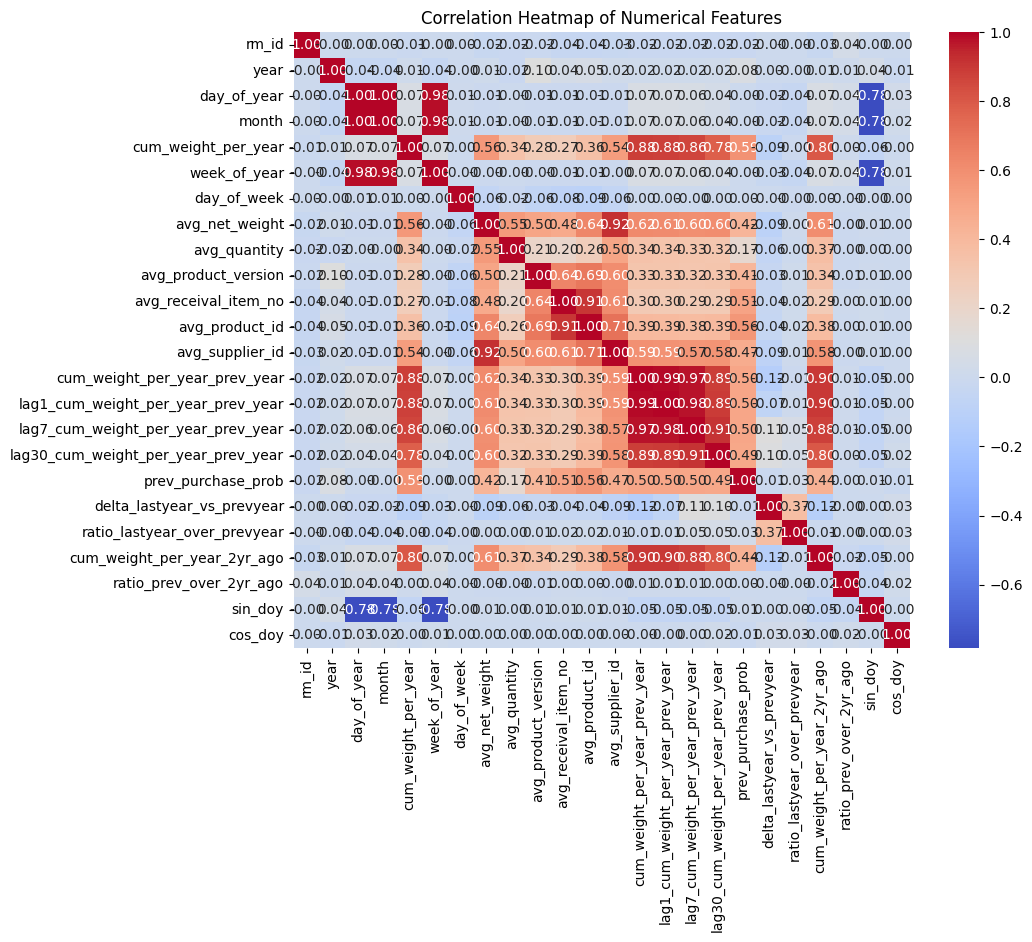

In [56]:
## # correlation heatmap for numerical features
numeric_cols = [col for col in df_model.columns if col != 'date_arrival']
plt.figure(figsize=(10, 8))
correlation_matrix = df_model[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

#### Here we dropped avg_gross_weight when we used materials and transports to get our dataset. Ended up not being necessary after all. 

In [57]:
# DROP AVG_GROSS_WEIGHT, AVG_MONTH AND AVG_YEAR
#df_rec_purchase = df_rec_purchase.drop(columns=['avg_gross_weight'])

#### Here we start by defining the quantile error metric, which will be used as an objective for the methods used.

#### We also define training and validation sets, which need to be time-based as our dataset is clearly time-related. So we define 2005-2023 to be training and then we validate on 2024. Now here, since the years close to each other are most likely correlated we have to use 2024 as validation, which is a shame as we would like to have it for training for predictions for the year after.

#### In addition, we also define the features, which end up being: 'year', 'week_of_year', 'sin_doy', 'cos_doy', 'lag1_cum_weight_per_year_prev_year', 'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear', 'prev_purchase_prob', 'lag7_cum_weight_per_year_prev_year', 'lag30_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year', 'cum_weight_per_year_2yr_ago', 'ratio_prev_over_2yr_ago'.

#### These were defined after a lot of model interpretation, using feature importance, then doing more model interpretation, selecting features and so on. What is curious is that it ended up being either just cumulative weight-related or time-related features, so not one single of the features given by the raw data, apart from weight and the time that were changed to fit the dataset. Another curious part is that our model does not use rm_id, which is curious as it is running strictly off of lag and ratio from years before.

#### Because we viewed both 2024 and 2023 and highly relevant for our model, we have also given these bigger weights (5 for 2024, 3 for 2023, while 1 for the rest of the years).

#### It is also important to note that the two Kaggle submissions use different sets of features. The first Kaggle model, which achieved the our lowest error on the leaderboard, includes all the features mentioned earlier. In contrast the second model, which performed slightly worse, does not include the features related to the cumulative weight from the two previous years or its ratio with the following year.

In [58]:
# =====================================================
# 1. Imports & Setup
# =====================================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

# =====================================================
# 2. Custom Quantile Error Metric
# =====================================================

class ParticipantVisibleError(Exception):
    """Raise this for participant-facing errors."""
    pass


def quantile_error(actual: np.ndarray, predicted: np.ndarray, q: float = 0.2) -> float:
    """Quantile loss (pinball loss) for quantile q."""
    if np.any(actual < 0) or np.any(predicted < 0):
        raise ParticipantVisibleError("Values must be non-negative.")

    diff = actual - predicted
    return np.mean(np.maximum(q * diff, (q - 1) * diff))


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "ID") -> float:
    """Compute 0.2 quantile error between true and predicted weights."""
    for col in [row_id_column_name, 'predicted_weight']:
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission is missing column: {col}")
    if not pd.api.types.is_numeric_dtype(submission['predicted_weight']):
        raise ParticipantVisibleError("'predicted_weight' in submission must be numeric.")

    submission_filtered = submission[submission[row_id_column_name].isin(solution[row_id_column_name])]
    merged = pd.merge(solution, submission_filtered, on=row_id_column_name, how='left', validate='one_to_one')

    if merged['predicted_weight'].isnull().any():
        missing_ids = merged.loc[merged['predicted_weight'].isnull(), row_id_column_name].tolist()
        raise ParticipantVisibleError(f"Missing predictions for ID(s): {missing_ids[:5]}")

    actual = merged['weight'].values
    predicted = merged['predicted_weight'].values
    result = quantile_error(actual, predicted, q=0.2)

    if not np.isfinite(result):
        raise ParticipantVisibleError("Final quantile error is not finite.")
    return float(result)


# =====================================================
# 3. Prepare Data
# =====================================================

df = df_model.copy()
df['date_arrival'] = pd.to_datetime(df['date_arrival'], errors='coerce')

target = 'cum_weight_per_year'

base_exclude = [
    'date_arrival', 'day_of_year', 'cum_weight_per_year',
    'avg_product_version', 'avg_product_id', 'avg_quantity',
    'avg_receival_item_no', 'day_of_week', 'avg_supplier_id'
]

# Build feature list (force include lag feature)
features = [
    col for col in df.columns
    if col not in base_exclude
    #and col not in ['year', 'month', 'day_of_year']
    and col in temporal_cols
] + ['lag1_cum_weight_per_year_prev_year', 'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear', 'prev_purchase_prob', 'lag7_cum_weight_per_year_prev_year', 'lag30_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year', 'cum_weight_per_year_2yr_ago', 'ratio_prev_over_2yr_ago']

print(features)

X = df[features]
y = df[target]

# One-hot encode categorical variables if any
X = pd.get_dummies(X, drop_first=True)

# =====================================================
# Define Time-Based Train/Validation Split
# =====================================================
df_rec_purchase['date_arrival'] = pd.to_datetime(df_rec_purchase['date_arrival'], errors='coerce')

cutoff_start = pd.Timestamp('2024-01-01')
cutoff_end = pd.Timestamp('2024-12-31')

is_valid = (df_rec_purchase['date_arrival'] >= cutoff_start) & (df_rec_purchase['date_arrival'] <= cutoff_end)
is_train = ~is_valid

# Sample weights: emphasize recent years
sample_weights = np.where(df['year'] == 2024, 5.0,
                  np.where(df['year'] == 2023, 3.0, 1.0))

X_train, y_train, w_train = X[is_train], y[is_train], sample_weights[is_train]
X_valid, y_valid, w_valid = X[is_valid], y[is_valid], sample_weights[is_valid]

print(f" Train: {len(X_train):,} | Valid: {len(X_valid):,}")
print(f"Train Range: {df_rec_purchase.loc[is_train, 'date_arrival'].min().date()} → {df_rec_purchase.loc[is_train, 'date_arrival'].max().date()}")
print(f"Valid Range: {df_rec_purchase.loc[is_valid, 'date_arrival'].min().date()} → {df_rec_purchase.loc[is_valid, 'date_arrival'].max().date()}")

def quantile_scorer(y_true, y_pred):
    return -quantile_error(y_true, y_pred, q=0.2)  # negative because sklearn maximizes the score

custom_scorer = make_scorer(quantile_scorer, greater_is_better=True)

['year', 'week_of_year', 'sin_doy', 'cos_doy', 'lag1_cum_weight_per_year_prev_year', 'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear', 'prev_purchase_prob', 'lag7_cum_weight_per_year_prev_year', 'lag30_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year', 'cum_weight_per_year_2yr_ago', 'ratio_prev_over_2yr_ago']
 Train: 1,275,660 | Valid: 67,260
Train Range: 2005-07-21 → 2023-12-31
Valid Range: 2024-01-01 → 2024-12-19


## TRAINING/VALIDATION

#### As we have mentioned before, we want methods that will use the NA values from our lag features in a smart and quick way. We ended therefore with 3 boosting methods: XGBoost, LightGBM and CatBoost. We have also tried Random Forest Trees and some simple MLP/ANN, however the Random Forest Trees were too time-taking and not very accurate and the MLP/ANN only worked prior to us using lag features that did not give NA values, as it needs full numerical input and we were not able to provide that in a logical way. 

#### In addition, it is worth mentioning that after filling our dataset with all possible dates, the training data had around 1.4 million rows which is very time-taking to train and validate, using all these methods. For that reason, we decided to only use a fraction of the dataset (25% seemed like an accurate and quick enough estimate, as it is normally around 20-30%), for hyperparameter tuning and validating to get the best possible hyperparameters. At the end we also thought that since we weren't using the full training data, it would be ok to retrain on 2024 and it would give more accurate results. However, we ended up realizing that training only until 2023 gave better test results, so we just used this instead.  

#### So we start with the XGBoost. We used a randomized search to tune the XGBoost model so it could learn effectively without overfitting or taking too long to train. The chosen parameter ranges control how complex the trees can grow, how fast the model learns, and how much regularization is applied to keep it stable. Randomized search was selected because it efficiently explores many possible combinations without testing every single one, saving time while still finding strong results. 3-fold cross-validation, with 15 iterations was used to not be too time-taking while keeping some sort of efficiency. This allows the model to be trained and tested on different parts of the data, making sure the performance is consistent and generalizes well to new, unseen data.

In [59]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform, loguniform

# =====================================================
# Subset for tuning (25%)
# =====================================================
q = 0.2  # quantile level
subset_frac = 0.25
X_tune = X_train.sample(frac=subset_frac, random_state=42)
subset_idx = X_tune.index
subset_pos = X_train.index.get_indexer(subset_idx)

if isinstance(y_train, pd.Series):
    y_tune = y_train.loc[subset_idx]
else:
    y_tune = y_train[subset_pos]

if isinstance(w_train, pd.Series):
    w_tune = w_train.loc[subset_idx]
else:
    w_tune = w_train[subset_pos]

# =====================================================
# XGBoost model setup
# =====================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',   # optimized for CPU
    predictor='auto',
    random_state=42,
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': randint(300, 800),
    'learning_rate': loguniform(0.01, 0.15),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': loguniform(1e-4, 5),
    'reg_lambda': loguniform(1e-3, 5),
    'gamma': uniform(0, 1)
}

# =====================================================
# Randomized SearchCV on subset
# =====================================================
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring=custom_scorer,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_tune, y_tune, sample_weight=w_tune)

best_xgb = xgb_search.best_estimator_
print("\n Best XGBoost Params:")
print(xgb_search.best_params_)

# =====================================================
# Fit best model on full train (2005–2023)
# =====================================================
best_xgb.fit(X_train, y_train, sample_weight=w_train)

# =====================================================
# Validation (2024)
# =====================================================
xgb_pred_valid = np.maximum(0, best_xgb.predict(X_valid))
xgb_val_score = quantile_error(y_valid.values, xgb_pred_valid, q=q)

print(f" Validation Quantile Error (q={q}): {xgb_val_score:.5f}")

# =====================================================
# Retrain on full data (2005–2024)
# =====================================================
best_xgb.fit(X, y, sample_weight=sample_weights)
print(" Retrained on full dataset (2005–2024).")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Best XGBoost Params:
{'colsample_bytree': np.float64(0.8123620356542087), 'gamma': np.float64(0.9507143064099162), 'learning_rate': np.float64(0.07259248719561363), 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 402, 'reg_alpha': np.float64(0.012443849002616567), 'reg_lambda': np.float64(0.0023431722468023933), 'subsample': np.float64(0.8377746675897602)}


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Validation Quantile Error (q=0.2): 46727.56780


c:\Users\bupat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Retrained on full dataset (2005–2024).


#### This was the code we use for Random Forest Trees. It ended up not being accurate and stable enough.

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint, uniform
#import numpy as np
#import pandas as pd

# ---------------------------
# Subset for faster hyperparameter tuning
# ---------------------------
#subset_frac = 0.25  # 25% of training data
#X_tune = X_train.sample(frac=subset_frac, random_state=42)

# Get integer positions of sampled rows
#subset_idx = X_tune.index
#subset_pos = X_train.index.get_indexer(subset_idx)  # ensures correct alignment even for numpy arrays

# Handle y_train safely
#if isinstance(y_train, pd.Series):
    #y_tune = y_train.loc[subset_idx]
#else:
    #y_tune = y_train[subset_pos]

# Handle w_train safely
#if isinstance(w_train, pd.Series):
    #w_tune = w_train.loc[subset_idx]
#else:
    #w_tune = w_train[subset_pos]

# ---------------------------
# Define Random Forest
# ---------------------------
#rf = RandomForestRegressor(random_state=42, n_jobs=-1)

#param_dist_rf = {
    #'n_estimators': randint(100, 500),
    #'max_depth': randint(6, 30),
    #'min_samples_split': randint(2, 15),
    #'min_samples_leaf': randint(1, 8),
    #'max_features': ['sqrt', 'log2'],
    #'bootstrap': [True],
#}

# ---------------------------
# RandomizedSearchCV (subset)
# ---------------------------
#rf_search = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_dist_rf,
    #n_iter=15,
    #scoring=custom_scorer,
    #cv=3,
    #random_state=42,
    #n_jobs=-1,
    #verbose=2
#)

# Fit on subset
#rf_search.fit(X_tune, y_tune, sample_weight=w_tune)

#best_rf = rf_search.best_estimator_
#print("\n Best Random Forest Params (subset tuning):")
#print(rf_search.best_params_)

# ---------------------------
# Refit on full training data
# ---------------------------
#best_rf.set_params(n_estimators=800)  # final number of trees
#best_rf.fit(X_train, y_train, sample_weight=w_train)

# ---------------------------
# Predict + Evaluate
# ---------------------------
#rf_pred = best_rf.predict(X_valid)
#rf_val_score = quantile_error(y_valid.values, rf_pred, q=0.2)
#print(f" Random Forest Validation Quantile Error (q=0.2): {rf_val_score:.5f}")


#### This LightGBM model was trained to run on a GPU if one was available, making the process faster and more efficient. The learning rate was set low so the model learns slowly and carefully, which helps it generalize better. Limits on tree depth, number of leaves, and the minimum number of samples per leaf keep the model from becoming too complex and overfitting the data. Random sampling of both features and rows adds randomness, helping the model stay balanced and not rely too much on any one part of the data. Regularization values were included to make the model more stable and prevent extreme predictions. Finally, early stopping was used so the training ends automatically when the model stops improving on the validation data. This setup helps build a model that is accurate, efficient, and able to make reliable predictions on new data.

In [60]:
import lightgbm as lgb
import numpy as np
import pandas as pd

subset_frac = 0.25
X_train_sub = X_train.sample(frac=subset_frac, random_state=42)

subset_idx = X_train_sub.index
subset_pos = X_train.index.get_indexer(subset_idx)

if isinstance(y_train, pd.Series):
    y_train_sub = y_train.loc[subset_idx]
else:
    y_train_sub = y_train[subset_pos]

if isinstance(w_train, pd.Series):
    w_train_sub = w_train.loc[subset_idx]
else:
    w_train_sub = w_train[subset_pos]

# =====================================================
# Prepare LightGBM datasets
# =====================================================
lgb_train = lgb.Dataset(X_train_sub, label=y_train_sub, weight=w_train_sub)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, weight=w_valid)

# =====================================================
# Choose compute device (GPU if available)
# =====================================================
try:
    _ = lgb.train({"device": "gpu", "verbose": -1},
                  lgb.Dataset(np.random.rand(10, 3), label=np.random.rand(10)))
    device_type = "gpu"
except Exception:
    device_type = "cpu"

print(f" Training LightGBM on device: {device_type.upper()}")

# =====================================================
# Define parameters
# =====================================================
lgb_params = {
    'objective': 'quantile',
    'alpha': q,
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 500,
    'max_depth': 12,
    'min_data_in_leaf': 40,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.05,
    'lambda_l2': 0.1,
    'boost_from_average': False,
    'verbosity': -1,
    'device': device_type
}

# =====================================================
# Train model (handle version differences)
# =====================================================
import lightgbm
lgb_version = tuple(map(int, lightgbm.__version__.split('.')[:2]))

if lgb_version >= (4, 0):
    callbacks = [
        lgb.early_stopping(stopping_rounds=30, verbose=True),
        lgb.log_evaluation(period=50)
    ]
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=callbacks
    )
else:
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=30,
        verbose_eval=50
    )

# =====================================================
# Validation (2024)
# =====================================================
lgb_pred_valid = np.maximum(0, lgb_model.predict(X_valid))
lgb_val_score = quantile_error(y_valid.values, lgb_pred_valid, q=q)

print(f" LightGBM ({device_type.upper()}) Validation Quantile Error (q={q}): {lgb_val_score:.5f}")

# =====================================================
# Retrain on full dataset (2005–2024)
# =====================================================
# Prepare full training data (2005–2024)
lgb_full = lgb.Dataset(X, label=y, weight=sample_weights)

if lgb_version >= (4, 0):
    lgb_model_full = lgb.train(
        params=lgb_params,
        train_set=lgb_full,
        num_boost_round=lgb_model.best_iteration or 500,
        valid_sets=[lgb_full],
        callbacks=[lgb.log_evaluation(period=100)]
    )
else:
    lgb_model_full = lgb.train(
        params=lgb_params,
        train_set=lgb_full,
        num_boost_round=lgb_model.best_iteration or 500,
        valid_sets=[lgb_full],
        verbose_eval=100
    )

print(" LightGBM retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.")

 Training LightGBM on device: GPU
Training until validation scores don't improve for 30 rounds
[50]	training's quantile: 33502.6	valid_1's quantile: 33779.2
[100]	training's quantile: 23635.3	valid_1's quantile: 28684.5
[150]	training's quantile: 17446.7	valid_1's quantile: 28068
[200]	training's quantile: 13610.8	valid_1's quantile: 27904.6
Early stopping, best iteration is:
[204]	training's quantile: 13468.2	valid_1's quantile: 27895.9
 LightGBM (GPU) Validation Quantile Error (q=0.2): 27890.84396
[100]	training's quantile: 23867.8
[200]	training's quantile: 13129.5
 LightGBM retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.


#### This CatBoost model was trained on the CPU because a GPU was not available. It was built to make accurate and stable predictions by combining a lot of small decision trees into one strong model. The parameters were selected to balance learning speed, model complexity, and generalization. A small learning rate helps the model learn gradually and avoid overfitting, while limits on tree depth and the regularization term controlled how detailed each tree can become. The feature sampling rate adds randomness, helping the model stay flexible and perform well on different data patterns. The Bayesian bootstrap method introduces small variations between trees, which makes the model more robust. Early stopping was used to end training automatically when performance on the validation set stopped improving, saving time and preventing unnecessary training. 

In [61]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool

# =====================================================
# Subsample 25% of training data for faster tuning
# =====================================================
subset_frac = 0.25
X_train_sub = X_train.sample(frac=subset_frac, random_state=42)

subset_idx = X_train_sub.index
subset_pos = X_train.index.get_indexer(subset_idx)

if isinstance(y_train, pd.Series):
    y_train_sub = y_train.loc[subset_idx]
else:
    y_train_sub = y_train[subset_pos]

if isinstance(w_train, pd.Series):
    w_train_sub = w_train.loc[subset_idx]
else:
    w_train_sub = w_train[subset_pos]

# =====================================================
# Prepare CatBoost pools
# =====================================================
train_pool = Pool(X_train_sub, label=y_train_sub, weight=w_train_sub)
valid_pool = Pool(X_valid, label=y_valid, weight=w_valid)

# =====================================================
#  Choose compute device (GPU if available)
# =====================================================
try:
    _ = CatBoostRegressor(task_type="GPU").fit(
        np.random.rand(10, 3), np.random.rand(10), verbose=False
    )
    device_type = "gpu"
except Exception:
    device_type = "cpu"

print(f" Training CatBoost on device: {device_type.upper()}")

# =====================================================
# Define parameters
# =====================================================
cat_params = {
    'loss_function': f'Quantile:alpha={q}',
    'eval_metric': f'Quantile:alpha={q}',
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 10,
    'l2_leaf_reg': 3.0,
    'rsm': 0.9,
    'random_strength': 1.0,
    'bootstrap_type': 'Bayesian',  # ← keep this
    # 'subsample': 0.8,             # ← remove this line
    'od_type': 'Iter',
    'od_wait': 30,
    'task_type': "GPU" if device_type == "gpu" else "CPU",
    'verbose': 100,
    'random_seed': 42
}

# =====================================================
# Train model
# =====================================================
cat_model = CatBoostRegressor(**cat_params)

cat_model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)

# =====================================================
# Validation (2024)
# =====================================================
cat_pred_valid = np.maximum(0, cat_model.predict(X_valid))
cat_val_score = quantile_error(y_valid.values, cat_pred_valid, q=q)
print(f" CatBoost ({device_type.upper()}) Validation Quantile Error (q={q}): {cat_val_score:.5f}")

# =====================================================
# Retrain on full dataset (2005–2024)
# =====================================================
full_pool = Pool(X, label=y, weight=sample_weights)

cat_model_full = CatBoostRegressor(**cat_params)
cat_model_full.fit(
    full_pool,
    verbose=100
)

print(" CatBoost retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.")

 Training CatBoost on device: CPU
0:	learn: 42116.2538620	test: 45282.3730181	best: 45282.3730181 (0)	total: 302ms	remaining: 5m 1s
100:	learn: 23822.1383487	test: 33060.0366857	best: 33060.0366857 (100)	total: 12.1s	remaining: 1m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 32752.32994
bestIteration = 112

Shrink model to first 113 iterations.
 CatBoost (CPU) Validation Quantile Error (q=0.2): 32746.53363
0:	learn: 42660.2594458	total: 397ms	remaining: 6m 36s
100:	learn: 22038.0331708	total: 36.2s	remaining: 5m 22s
200:	learn: 14447.8752783	total: 1m 10s	remaining: 4m 39s
300:	learn: 11898.8613841	total: 1m 45s	remaining: 4m 4s
400:	learn: 10567.5355043	total: 4m 4s	remaining: 6m 5s
500:	learn: 9755.6404919	total: 5m 20s	remaining: 5m 19s
600:	learn: 9081.0228521	total: 6m 11s	remaining: 4m 6s
700:	learn: 8713.7808379	total: 6m 45s	remaining: 2m 52s
800:	learn: 8285.0385757	total: 7m 18s	remaining: 1m 49s
900:	learn: 8126.9630074	total: 7m 51s	remaining: 51.8s

#### This was the code used for ANN/MLP. It ended up not being accurate/stable enough

In [ ]:
#import torch
#from torch import nn
#from torch.utils.data import DataLoader, TensorDataset
#import numpy as np
#import pandas as pd

# =====================================================
# Quantile loss function
# =====================================================
#q = 0.2

#def quantile_loss(y_pred, y_true, q=q):
    #residual = y_true - y_pred
    #return torch.mean(torch.max(q * residual, (q - 1) * residual))

#def quantile_error(y_true, y_pred, q=q):
    #residual = y_true - y_pred
    #return np.mean(np.maximum(q * residual, (q - 1) * residual))

# =====================================================
# MLP model definition
# =====================================================
#class QuantileMLP(nn.Module):
    #def __init__(self, n_features, hidden=[128, 64]):
        #super().__init__()
        #layers = []
        #in_features = n_features
        #for h in hidden:
            #layers.append(nn.Linear(in_features, h))
            #layers.append(nn.ReLU())
            #in_features = h
        #layers.append(nn.Linear(in_features, 1))
        #self.model = nn.Sequential(*layers)
        
    #def forward(self, x):
        #return self.model(x)

# =====================================================
# Device setup
# =====================================================
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

# =====================================================
# Subset 25% of training data for faster training (tuning phase)
# =====================================================
#subset_frac = 0.25
#X_tune = X_train.sample(frac=subset_frac, random_state=42)

# Align y accordingly
#if isinstance(y_train, pd.Series):
    #y_tune = y_train.loc[X_tune.index]
#else:
    #y_tune = y_train[X_tune.index]

# Convert validation set
#X_valid_t = torch.tensor(X_valid.values, dtype=torch.float32).to(device)
#y_valid_t = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1).to(device)

# Convert subset training set
#X_train_t = torch.tensor(X_tune.values, dtype=torch.float32).to(device)
#y_train_t = torch.tensor(y_tune.values, dtype=torch.float32).unsqueeze(1).to(device)

# DataLoaders
#train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=2048, shuffle=True)
#valid_loader = DataLoader(TensorDataset(X_valid_t, y_valid_t), batch_size=2048, shuffle=False)

# =====================================================
# Initialize model and optimizer
# =====================================================
#model_mlp = QuantileMLP(n_features=X_train.shape[1], hidden=[128, 64]).to(device)
#optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

# =====================================================
# Training loop (10 epochs)
# =====================================================
#epochs = 10
#for epoch in range(epochs):
    #model_mlp.train()
    #running_loss = 0.0
    #for xb, yb in train_loader:
        #optimizer.zero_grad()
        #loss = quantile_loss(model_mlp(xb), yb)
        #loss.backward()
        #optimizer.step()
        #running_loss += loss.item() * xb.size(0)
    #epoch_loss = running_loss / len(train_loader.dataset)
    #print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.5f}")

# =====================================================
# Validation (2024)
# =====================================================
#model_mlp.eval()
#with torch.no_grad():
    #y_pred_mlp = model_mlp(X_valid_t).cpu().numpy()
#y_pred_mlp = np.maximum(0, y_pred_mlp.flatten())

#mlp_val_score = quantile_error(y_valid.values, y_pred_mlp, q=q)
#print(f" ANN/MLP Validation Quantile Error (q={q}): {mlp_val_score:.5f}")

# =====================================================
#Retrain on full dataset (2005–2024)
# =====================================================
# Convert all data to tensors
#X_full_t = torch.tensor(X.values, dtype=torch.float32).to(device)
#y_full_t = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(device)

#full_loader = DataLoader(TensorDataset(X_full_t, y_full_t), batch_size=2048, shuffle=True)

# New model for full retraining (fresh start)
#model_mlp_full = QuantileMLP(n_features=X.shape[1], hidden=[128, 64]).to(device)
#optimizer_full = torch.optim.Adam(model_mlp_full.parameters(), lr=0.001)

#epochs_full = 15
#for epoch in range(epochs_full):
    #model_mlp_full.train()
    #running_loss = 0.0
    #for xb, yb in full_loader:
        #optimizer_full.zero_grad()
        #loss = quantile_loss(model_mlp_full(xb), yb)
        #loss.backward()
        #optimizer_full.step()
        #running_loss += loss.item() * xb.size(0)
    #epoch_loss = running_loss / len(full_loader.dataset)
    #print(f"[Full Retrain] Epoch {epoch+1}/{epochs_full} | Loss: {epoch_loss:.5f}")

#print(" ANN/MLP retrained on full dataset (2005–2024). Ready for 2025 predictions in next cell.")

#### Here we choose the more accurate validation model, which ended up being the LightGBM. 

#### Here we also see that the validation error is quite big for the best model, however we must take into account that we have defined higher weights for 2023 and 2024, and our model was not trained in 2024, only up to 2023, so this could be the reason it gives such a big error.

In [62]:
val_scores = {
    "XGBoost (GPU)": xgb_val_score,
    "LightGBM (GPU)": lgb_val_score,
    "CatBoost (CPU)": cat_val_score,
}

best_model_name = min(val_scores, key=val_scores.get)

if best_model_name == "XGBoost (GPU)":
    final_model = best_xgb
elif best_model_name == "LightGBM (GPU)":
    final_model = lgb_model
else:
    final_model = cat_model

print(f"\n Best Model Selected: {best_model_name}")
print(f"Validation Quantile Error: {val_scores[best_model_name]:.5f}")



 Best Model Selected: LightGBM (GPU)
Validation Quantile Error: 27890.84396


#### This is the code that we used for the model interpretation, which we have mentioned before and used for feature selection. We have used feature importance to determine this. The delta feature and the cyclical features were the least relevant however, we were not able to test whether these end up being relevant or not for the model, due to lack of time from our part, so we just decided to keep them in, as our model is performing somewhat alright. 

 Displaying LightGBM Feature Importances...


C:\Users\bupat\AppData\Local\Temp\ipykernel_6704\1416455983.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


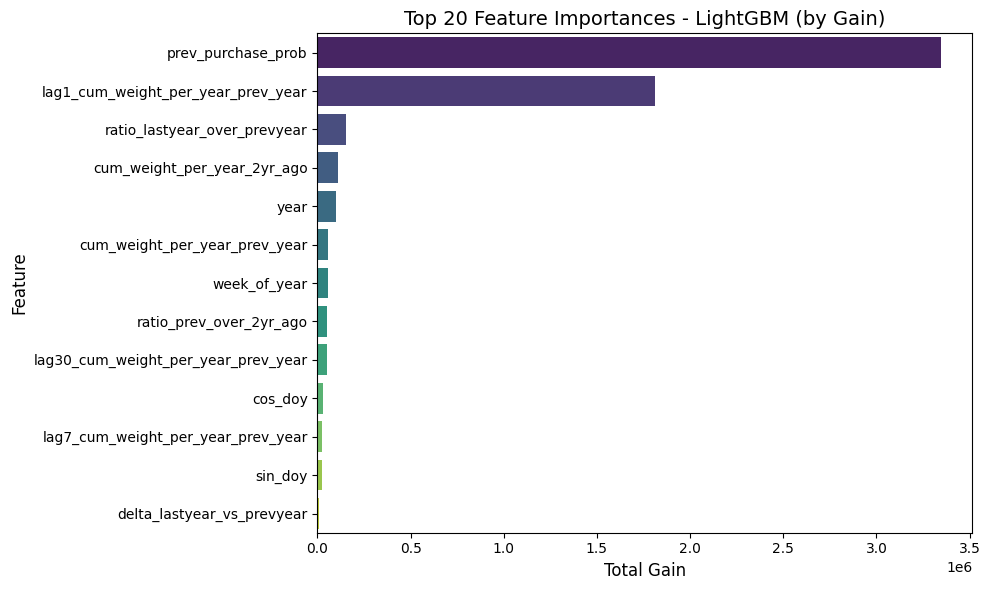

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ============================================================
# Feature Importance for LightGBM Booster
# ============================================================

# Ensure this only runs if the model is a LightGBM Booster
if isinstance(lgb_model, lgb.Booster):
    print(" Displaying LightGBM Feature Importances...")

    # Extract feature importance and names
    importance_df = pd.DataFrame({
        'Feature': lgb_model.feature_name(),
        'Importance': lgb_model.feature_importance(importance_type='gain')  # 'gain' = total info gain
    })

    # Sort descending
    importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title("Top 20 Feature Importances - LightGBM (by Gain)", fontsize=14)
    plt.xlabel("Total Gain", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print(" The current model is not a LightGBM Booster — skipping feature importance plot.")

#### This is also a code for model interpretation, however it would only be ran in case of LightGBM not being the most accurate model. 

In [64]:
# ============================================================
# 6. Model Interpretation (Feature Importance + PDP)
# ============================================================
#if hasattr(final_model, "feature_importances_"):
    #importances = pd.Series(final_model.feature_importances_, index=X.columns)
    #top_importances = importances.sort_values(ascending=False).head(20)

    #plt.figure(figsize=(10, 6))
    #sns.barplot(x=top_importances.values, y=top_importances.index)
    #plt.title(f"Top 20 Feature Importances - {best_model_name}")
    #plt.tight_layout()
    #plt.show()

    #top_features = top_importances.index[:3]
    #print(f"Plotting PDPs for: {list(top_features)}")
    #PartialDependenceDisplay.from_estimator(final_model, X, features=top_features)
    #plt.show()

## PREDICTIONS

#### For predictions, we need to change the prediction mapping so it fits the features for our model. So we start by defining all time-related features. 

In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# Ensure trained model exists
# ============================================================
try:
    model = final_model
except NameError:
    if 'best_xgb' in globals():
        model = best_xgb
    #elif 'best_rf' in globals():
        #model = best_rf
    elif 'lgb_model' in globals():
        model = lgb_model
    elif 'cat_model' in globals():
        model = cat_model
    else:
        raise NameError(" No trained model found. Run training first.")

pm_df = prediction_mapping.copy()

# --- Ensure date type ---
pm_df['forecast_end_date'] = pd.to_datetime(pm_df['forecast_end_date'], errors='coerce')

# --- Core calendar breakdown ---
pm_df['year'] = pm_df['forecast_end_date'].dt.year
pm_df['month'] = pm_df['forecast_end_date'].dt.month
pm_df['week_of_year'] = pm_df['forecast_end_date'].dt.isocalendar().week.astype(int)
pm_df['day_of_week'] = pm_df['forecast_end_date'].dt.dayofweek
pm_df['day_of_year'] = pm_df['forecast_end_date'].dt.dayofyear
pm_df['rm_id'] = pm_df['rm_id'].astype(str)

# ============================================================
# Cyclical encodings for seasonality
# ============================================================
pm_df['sin_doy'] = np.sin(2 * np.pi * pm_df['day_of_year'] / 365)
pm_df['cos_doy'] = np.cos(2 * np.pi * pm_df['day_of_year'] / 365)

# ============================================================
# Summary check
# ============================================================
temporal_cols = ['year', 'week_of_year',
    'sin_doy', 'cos_doy'
]

print(f" Prediction mapping (2025): {pm_df.shape}")
print(f" Added {len(temporal_cols) - 1} temporal features.")
display(pm_df[temporal_cols].head(10))

 Prediction mapping (2025): (30450, 11)
 Added 3 temporal features.


,year,week_of_year,sin_doy,cos_doy
0,2025,1,0.034422,0.999407
1,2025,1,0.051620,0.998667
2,2025,1,0.068802,0.997630
3,2025,1,0.085965,0.996298
4,2025,2,0.103102,0.994671
5,2025,2,0.120208,0.992749
6,2025,2,0.137279,0.990532
7,2025,2,0.154309,0.988023
8,2025,2,0.171293,0.985220
9,2025,2,0.188227,0.982126


#### Then we need our lag features and prior years features. These go at most 2 years prior, so we will need data from 2023 and 2024. So we create a dataset to make that easier. 

In [66]:
# ============================================================
# Prepare base dataset (2023–2024 only)
# ============================================================
df_feat = df_rec_purchase[df_rec_purchase['year'].isin([2023, 2024])].copy()
df_feat['date_arrival'] = pd.to_datetime(df_feat['date_arrival'], errors='coerce')
df_feat['rm_id'] = df_feat['rm_id'].astype(str)
df_feat['week_of_year'] = df_feat['date_arrival'].dt.isocalendar().week.astype(int)
df_feat['day_of_week'] = df_feat['date_arrival'].dt.dayofweek
df_feat = df_feat.sort_values(['rm_id', 'year', 'week_of_year', 'day_of_week'])

print(" df_feat (2023–2024):", df_feat.shape)
df_feat.head()

 df_feat (2023–2024): (136800, 34)


,rm_id,date_arrival,year,day_of_year,month,net_weight,quantity,product_version,receival_item_no,product_id,...,prev_purchase_prob,days_with_purchase,total_days,delta_lastyear_vs_prevyear,ratio_lastyear_over_prevyear,cum_weight_per_year_2yr_ago,ratio_prev_over_2yr_ago,quarter,sin_doy,cos_doy
218389,1842.0,2023-01-02,2023,2,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,0.0,NaN,NaN,NaN,1,0.034422,0.999407
218390,1842.0,2023-01-03,2023,3,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,0.0,NaN,NaN,NaN,1,0.051620,0.998667
218391,1842.0,2023-01-04,2023,4,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,0.0,NaN,0.0,NaN,1,0.068802,0.997630
218392,1842.0,2023-01-05,2023,5,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,0.0,NaN,0.0,NaN,1,0.085965,0.996298
218393,1842.0,2023-01-06,2023,6,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.0,0.0,NaN,0.0,NaN,1,0.103102,0.994671


#### Now, we compute the lag features for 2024, as well as the 2 years prior feature, and put both in their respective dataframes, which will help us merge them towards a final features dataframe and then merge these again to the prediction mapping.

In [67]:
# ============================================================
# Compute lag features (2024 only)
# ============================================================
df_2024 = df_feat[df_feat['year'] == 2024].copy()

# --- Drop any old duplicate columns before computing ---
df_2024 = df_2024.loc[:, ~df_2024.columns.duplicated()].copy()

# --- Compute lags grouped by rm_id ---
for lag in [1, 7, 30]:
    df_2024[f'lag{lag}_cum_weight_per_year_prev_year'] = (
        df_2024.groupby('rm_id')['cum_weight_per_year'].shift(lag)
    )

# --- Remove any existing cum_weight_per_year_prev_year before renaming ---
if 'cum_weight_per_year_prev_year' in df_2024.columns:
    df_2024 = df_2024.drop(columns=['cum_weight_per_year_prev_year'])

# --- Rename current year's cum_weight for clarity ---
df_2024 = df_2024.rename(columns={
    'cum_weight_per_year': 'cum_weight_per_year_prev_year'
})

# --- Keep only what we need for lag map ---
lag_map_2024 = (
    df_2024[[
        'rm_id',
        'week_of_year',
        'day_of_week',
        'cum_weight_per_year_prev_year',
        'lag1_cum_weight_per_year_prev_year',
        'lag7_cum_weight_per_year_prev_year',
        'lag30_cum_weight_per_year_prev_year'
    ]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print(f" lag_map_2024 created successfully: {lag_map_2024.shape}")
print(lag_map_2024.head(10))

# ============================================================
# Create 2-years-ago features (from 2023 for 2025 use)
# ============================================================
df_2023 = df_feat[df_feat['year'] == 2023].copy()

# Drop duplicate columns if any
df_2023 = df_2023.loc[:, ~df_2023.columns.duplicated()].copy()

# Prepare the 2023 mapping (same structure as lag_map_2024)
lag_map_2023 = (
    df_2023[['rm_id', 'week_of_year', 'day_of_week', 'cum_weight_per_year']]
    .rename(columns={'cum_weight_per_year': 'cum_weight_per_year_2yr_ago'})
    .drop_duplicates()
    .reset_index(drop=True)
)

print(f" lag_map_2023 created successfully: {lag_map_2023.shape}")
print(lag_map_2023.head(5))

 lag_map_2024 created successfully: (67260, 7)
    rm_id  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
0  1842.0             1            0                            0.0   
1  1842.0             1            1                            0.0   
2  1842.0             1            2                            0.0   
3  1842.0             1            3                            0.0   
4  1842.0             1            4                            0.0   
5  1842.0             1            5                            0.0   
6  1842.0             1            6                            0.0   
7  1842.0             2            0                            0.0   
8  1842.0             2            1                            0.0   
9  1842.0             2            2                            0.0   

   lag1_cum_weight_per_year_prev_year  lag7_cum_weight_per_year_prev_year  \
0                                 NaN                                 NaN   
1                

#### This code was used to create the 2-year prior average features, for features that were in the receivals and purchase raw data. Because of feature importance, these ended up being not so relevant, however these were still used quite a lot until we realized we should not use them for modelling.

In [68]:
# ============================================================
# 2-year averages (2023 + 2024)
# ============================================================
avg_features_df = (
    df_feat.groupby(['rm_id', 'week_of_year', 'day_of_week'], as_index=False)
    .agg({
        'quantity': 'mean',
        'net_weight': 'mean',
        'receival_item_no': 'mean',
        'supplier_id': 'mean',
    })
)
avg_features_df = avg_features_df.rename(columns={
    'quantity': 'avg_quantity',
    'net_weight': 'avg_net_weight',
    'receival_item_no': 'avg_receival_item_no',
    'supplier_id': 'avg_supplier_id',
})

print(" avg_features_df:", avg_features_df.shape)
avg_features_df.head()


 avg_features_df: (69160, 7)


,rm_id,week_of_year,day_of_week,avg_quantity,avg_net_weight,avg_receival_item_no,avg_supplier_id
0,1842.0,1,0,0.0,0.0,0.0,0.0
1,1842.0,1,1,0.0,0.0,0.0,0.0
2,1842.0,1,2,0.0,0.0,0.0,0.0
3,1842.0,1,3,0.0,0.0,0.0,0.0
4,1842.0,1,4,0.0,0.0,0.0,0.0


#### Then we define the probability of purchase for each of the rm_ids, using October to December of 2024.

In [69]:
# ============================================================
# Previous purchase probability (Oct–Dec 2024)
# ============================================================
df_prob = df_rec_purchase.copy()
df_prob['date_arrival'] = pd.to_datetime(df_prob['date_arrival'], errors='coerce')
df_prob['year'] = df_prob['date_arrival'].dt.year
df_prob['month'] = df_prob['date_arrival'].dt.month
df_prob['rm_id'] = df_prob['rm_id'].astype(str)
df_prob['purchase_flag'] = (df_prob['net_weight'] > 0).astype(int)

df_prob_oct_dec = df_prob[(df_prob['year'] == 2024) & (df_prob['month'].isin([10, 11, 12]))]
purchase_prob_df = (
    df_prob_oct_dec.groupby('rm_id', as_index=False)
    .agg(
        days_with_purchase=('purchase_flag', 'sum'),
        total_days=('date_arrival', 'nunique')
    )
)
purchase_prob_df['prev_purchase_prob'] = (
    purchase_prob_df['days_with_purchase'] / purchase_prob_df['total_days']
)

print(" purchase_prob_df:", purchase_prob_df.shape)
purchase_prob_df.head()

 purchase_prob_df: (190, 4)


,rm_id,days_with_purchase,total_days,prev_purchase_prob
0,1842.0,0,80,0.0
1,1843.0,0,80,0.0
2,1844.0,0,80,0.0
3,1845.0,0,80,0.0
4,1846.0,0,80,0.0


#### As mentioned before, we merge all created dataframes with the possible features into one dataframe.

In [70]:
# ============================================================
# Combine all feature sets (2023–2024)
# ============================================================

# --- Standardize key dtypes across all DataFrames ---
for df in [avg_features_df, lag_map_2024]:
    df['rm_id'] = (
        df['rm_id']
        .astype(str)
        .str.replace('.0', '', regex=False)
        .str.strip()
    )
    df['week_of_year'] = df['week_of_year'].astype(int)
    df['day_of_week'] = df['day_of_week'].astype(int)

purchase_prob_df['rm_id'] = (
    purchase_prob_df['rm_id']
    .astype(str)
    .str.replace('.0', '', regex=False)
    .str.strip()
)

# --- Also standardize lag_map_2023 if it exists ---
if 'lag_map_2023' in locals():
    lag_map_2023['rm_id'] = (
        lag_map_2023['rm_id']
        .astype(str)
        .str.replace('.0', '', regex=False)
        .str.strip()
    )
    lag_map_2023['week_of_year'] = lag_map_2023['week_of_year'].astype(int)
    lag_map_2023['day_of_week'] = lag_map_2023['day_of_week'].astype(int)
else:
    raise KeyError("lag_map_2023 not found. Please create it first (from df_feat[df_feat['year']==2023]).")

# --- Restrict avg_features_df to keys that exist in lag_map_2024 ---
valid_keys = lag_map_2024[['rm_id', 'week_of_year', 'day_of_week']].drop_duplicates()
avg_features_df = avg_features_df.merge(
    valid_keys,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='inner'
)

print(f" Key alignment check:")
print(f"   avg_features_df: {len(avg_features_df):,} rows")
print(f"   lag_map_2024: {len(lag_map_2024):,} rows")

# --- Merge avg + lag features (same keys) ---
features_df = avg_features_df.merge(
    lag_map_2024,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='left'
)

# --- Merge 2-years-ago features (lag_map_2023) ---
features_df = features_df.merge(
    lag_map_2023[['rm_id', 'week_of_year', 'day_of_week', 'cum_weight_per_year_2yr_ago']],
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='left'
)

# --- Add prev_purchase_prob (by rm_id only) ---
features_df = features_df.merge(
    purchase_prob_df[['rm_id', 'prev_purchase_prob']],
    on='rm_id',
    how='left'
)

# --- Compute delta and ratio (previous-year vs lag7) ---
required_cols = ['lag7_cum_weight_per_year_prev_year', 'cum_weight_per_year_prev_year']
missing = [c for c in required_cols if c not in features_df.columns]
if missing:
    raise KeyError(f"Missing required columns in features_df: {missing}")

# Delta (7-day lag vs previous-year cumulative)
features_df['delta_lastyear_vs_prevyear'] = (
    features_df['lag7_cum_weight_per_year_prev_year'] -
    features_df['cum_weight_per_year_prev_year']
)

# Ratio (7-day lag vs previous-year cumulative)
features_df['ratio_lastyear_over_prevyear'] = np.where(
    features_df['cum_weight_per_year_prev_year'] != 0,
    features_df['lag7_cum_weight_per_year_prev_year'] / features_df['cum_weight_per_year_prev_year'],
    np.nan
)

# --- Compute ratio between previous-year and 2-years-ago ---
if 'cum_weight_per_year_2yr_ago' in features_df.columns:
    features_df['ratio_prev_over_2yr_ago'] = np.where(
        features_df['cum_weight_per_year_2yr_ago'] != 0,
        features_df['cum_weight_per_year_prev_year'] / features_df['cum_weight_per_year_2yr_ago'],
        np.nan
    )
else:
    print(" cum_weight_per_year_2yr_ago not found — skipping ratio_prev_over_2yr_ago computation.")

# --- Final consistency checks ---
missing_lags = features_df['lag7_cum_weight_per_year_prev_year'].isna().sum()
missing_2yr = features_df['cum_weight_per_year_2yr_ago'].isna().sum()

print(f" features_df (combined): {features_df.shape}")
print(f" Missing lag7 values after merge: {missing_lags:,}")
print(f" Missing 2-year-ago values after merge: {missing_2yr:,}")
print(f" Added delta_lastyear_vs_prevyear, ratio_lastyear_over_prevyear, and ratio_prev_over_2yr_ago")

# ---  Preview key columns ---
print(features_df[
    ['rm_id', 'week_of_year', 'day_of_week',
     'cum_weight_per_year_prev_year', 'cum_weight_per_year_2yr_ago',
     'ratio_prev_over_2yr_ago',
     'lag1_cum_weight_per_year_prev_year', 'lag7_cum_weight_per_year_prev_year',
     'lag30_cum_weight_per_year_prev_year',
     'delta_lastyear_vs_prevyear', 'ratio_lastyear_over_prevyear']
].head(10))


 Key alignment check:
   avg_features_df: 67,260 rows
   lag_map_2024: 67,260 rows
 features_df (combined): (67260, 16)
 Missing lag7 values after merge: 1,330
 Missing 2-year-ago values after merge: 0
 Added delta_lastyear_vs_prevyear, ratio_lastyear_over_prevyear, and ratio_prev_over_2yr_ago
  rm_id  week_of_year  day_of_week  cum_weight_per_year_prev_year  \
0  1842             1            0                            0.0   
1  1842             1            1                            0.0   
2  1842             1            2                            0.0   
3  1842             1            3                            0.0   
4  1842             1            4                            0.0   
5  1842             1            5                            0.0   
6  1842             1            6                            0.0   
7  1842             2            0                            0.0   
8  1842             2            1                            0.0   
9  1842        

#### Then merge the features into the prediction mapping

In [71]:
# ============================================================
# Merge computed features into 2025 prediction mapping
# ============================================================

# Ensure keys have consistent dtypes
for df in [pm_df, features_df]:
    df['rm_id'] = (
        df['rm_id']
        .astype(str)
        .str.replace('.0', '', regex=False)
        .str.strip()
    )
    df['week_of_year'] = df['week_of_year'].astype(int)
    df['day_of_week'] = df['day_of_week'].astype(int)

# Merge by rm_id + week_of_year + day_of_week (no forward fill)
pred_df = pm_df.merge(
    features_df,
    on=['rm_id', 'week_of_year', 'day_of_week'],
    how='left'
)

# Fill missing numeric feature values with zero
num_cols = pred_df.select_dtypes(include=[np.number]).columns
#pred_df[num_cols] = pred_df[num_cols].fillna(0)

print(f" pred_df after merging and filling: {pred_df.shape}")
print(f"   Remaining NaN values (should be 0): {pred_df.isna().sum().sum()}")

# Quick check of sample rows
pred_df.head(10)

 pred_df after merging and filling: (30450, 24)
   Remaining NaN values (should be 0): 78386


,ID,rm_id,forecast_start_date,forecast_end_date,year,month,week_of_year,day_of_week,day_of_year,sin_doy,...,avg_supplier_id,cum_weight_per_year_prev_year,lag1_cum_weight_per_year_prev_year,lag7_cum_weight_per_year_prev_year,lag30_cum_weight_per_year_prev_year,cum_weight_per_year_2yr_ago,prev_purchase_prob,delta_lastyear_vs_prevyear,ratio_lastyear_over_prevyear,ratio_prev_over_2yr_ago
0,1,365,2025-01-01,2025-01-02,2025,1,1,3,2,0.034422,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,2,365,2025-01-01,2025-01-03,2025,1,1,4,3,0.051620,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2,3,365,2025-01-01,2025-01-04,2025,1,1,5,4,0.068802,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,4,365,2025-01-01,2025-01-05,2025,1,1,6,5,0.085965,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,5,365,2025-01-01,2025-01-06,2025,1,2,0,6,0.103102,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
5,6,365,2025-01-01,2025-01-07,2025,1,2,1,7,0.120208,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
6,7,365,2025-01-01,2025-01-08,2025,1,2,2,8,0.137279,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
7,8,365,2025-01-01,2025-01-09,2025,1,2,3,9,0.154309,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
8,9,365,2025-01-01,2025-01-10,2025,1,2,4,10,0.171293,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN
9,10,365,2025-01-01,2025-01-11,2025,1,2,5,11,0.188227,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN


#### Check if all features are available, and how many values are missing. The ratio features have a lot of them as a lot of the rm_ids did not have purchases for those days so dividing by zero gives of course a NA value.

In [72]:
# ============================================================
# Align features for model
# ============================================================
if hasattr(model, "feature_name"):
    model_features = list(model.feature_name())
elif hasattr(model, "feature_names_in_"):
    model_features = list(model.feature_names_in_)
elif hasattr(model, "get_booster"):
    model_features = list(model.get_booster().feature_names)
else:
    model_features = list(X_train.columns)

for f in model_features:
    if f not in pred_df.columns:
        pred_df[f] = np.nan

X_pred = pred_df[model_features].apply(pd.to_numeric, errors='coerce')

print(" Model features found:", len(model_features))
print("Missing values per feature:\n", X_pred.isna().sum())

 Model features found: 13
Missing values per feature:
 year                                       0
week_of_year                               0
sin_doy                                    0
cos_doy                                    0
lag1_cum_weight_per_year_prev_year      1950
delta_lastyear_vs_prevyear              2710
ratio_lastyear_over_prevyear           24927
prev_purchase_prob                      1950
lag7_cum_weight_per_year_prev_year      2710
lag30_cum_weight_per_year_prev_year     7080
cum_weight_per_year_prev_year           1950
cum_weight_per_year_2yr_ago             1950
ratio_prev_over_2yr_ago                25359
dtype: int64


#### This is the final code for predictions, using just LightGBM, and then creating the submission file for Kaggle with just the ID and the predicted_weight. Note that we realized that for years prior there were very few deliveries on the first week of January, right after vacaction, so we just masked this to zero.

In [73]:
# ============================================================
# Predict cum_weight_year directly
# ============================================================
pred_df['predicted_weight'] = np.maximum(0, model.predict(X_pred))

# ============================================================
# Mask week 1 of 2025
# ============================================================
mask_week1_2025 = (pred_df['year'] == 2025) & (pred_df['week_of_year'] == 1)
pred_df.loc[mask_week1_2025, 'predicted_weight'] = 0

# ============================================================
# Save Final Submission
# ============================================================
submission = pred_df[['ID', 'predicted_weight']].drop_duplicates(subset=['ID']).sort_values(by='ID')
submission.to_csv("submission_2025_predictions_cumweightyear_TEST.csv", index=False)

print(" Final 2025 predictions ready!")
print("Submission shape:", submission.shape)
submission.head()

 Final 2025 predictions ready!
Submission shape: (30450, 2)


,ID,predicted_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


#### It is also worth mentioning that when we tried to predict just for net_weight, then mask by putting to zero on weekends (no deliveries here), or non-available rm_ids on training, or for the first week of January like when predicting for the cumulative weight and the last one was for the days in the past that there were no combinations of rm_id, day_of_week and week_of_year with combinations. This is the code we used for that, but ended up dropping because predicting for cumulative weight would be more accurate.

In [ ]:
#import pandas as pd
#import numpy as np

# ============================================================
# Ensure trained model exists
# ============================================================
#try:
    #model = final_model
#except NameError:
    #if 'best_xgb' in globals():
        #model = best_xgb
    #elif 'best_rf' in globals():
        #model = best_rf
    #else:
        #raise NameError("No trained model found. Run training first.")

# ============================================================
# 1️⃣ Prepare prediction mapping
# ============================================================
#pm_df = prediction_mapping.copy()
#pm_df['forecast_end_date'] = pd.to_datetime(pm_df['forecast_end_date'], errors='coerce')
#pm_df['month'] = pm_df['forecast_end_date'].dt.month
#pm_df['day_of_week'] = pm_df['forecast_end_date'].dt.weekday  # Monday=0
#pm_df['week_of_year'] = pm_df['forecast_end_date'].dt.isocalendar().week.astype(int)
#pm_df['year'] = pm_df['forecast_end_date'].dt.year

# ============================================================
# 2️⃣ Compute 2-year rolling features from 2023–2024
# ============================================================
#rolling_features = ['net_weight', 'quantity', 'supplier_id']
#df_rolling = df_rec_purchase[df_rec_purchase['year'].isin([2023, 2024])].copy()

#roll2yr_df = (
    #df_rolling
    #.groupby(['rm_id', 'week_of_year', 'day_of_week'])[rolling_features]
    #.mean()
    #.reset_index()
#)
#roll2yr_df = roll2yr_df.rename(columns={c: f'roll2yr_{c}' for c in rolling_features})

# ============================================================
# 3️⃣ Extract avg features and purchase_prob
# ============================================================
#avg_features = [c for c in df_rec_purchase.columns if c.startswith('avg_')]
#purchase_prob_df = df_rec_purchase[['rm_id', 'purchase_prob']].drop_duplicates(subset=['rm_id'])

#rm_features_df = df_rec_purchase[['rm_id', 'week_of_year', 'day_of_week'] + avg_features].drop_duplicates()
#rm_features_df = rm_features_df.merge(purchase_prob_df, on='rm_id', how='left')
#rm_features_df = rm_features_df.merge(roll2yr_df, on=['rm_id', 'week_of_year', 'day_of_week'], how='left')

# ============================================================
# 4️⃣ Keep only combinations that existed in 2024
# ============================================================
#valid_2024 = df_rec_purchase.loc[
    #df_rec_purchase['year'] == 2024,
    #['rm_id', 'week_of_year', 'day_of_week']
#].drop_duplicates()
#rm_features_df = rm_features_df.merge(valid_2024, on=['rm_id', 'week_of_year', 'day_of_week'], how='inner')

# ============================================================
# 5️⃣ Merge features into prediction mapping
# ============================================================
#pred_df = pm_df.merge(rm_features_df, on=['rm_id', 'week_of_year', 'day_of_week'], how='left')

# ============================================================
# 6️⃣ Align feature order exactly as in training
# ============================================================
#required_features = model.feature_names_in_
#for c in required_features:
    #if c not in pred_df.columns:
        #pred_df[c] = 0
#X_pred = pred_df[required_features].fillna(0)

# ============================================================
# 7️⃣ Predict Net Weight
# ============================================================
#pred_df['predicted_net_weight'] = model.predict(X_pred)
#pred_df['predicted_net_weight'] = np.maximum(0, pred_df['predicted_net_weight'])

# ============================================================
# 8️⃣ Random selection of active weekdays per RM_ID/month
# ============================================================
# Compute active weekdays in 2024 per RM_ID/month
#active_2024 = (
    #df_rec_purchase.loc[
        #(df_rec_purchase['year'] == 2024) &
        #(df_rec_purchase['day_of_week'] < 5)
    #]
    #.assign(month=lambda df: df['date_arrival'].dt.month)
    #.groupby(['rm_id', 'month'])['day_of_week']
    #.nunique()
    #.reset_index(name='active_days_2024')
#)

# Determine target number of days to predict (e.g., 60% of active days)
#active_2024['target_days_2025'] = np.ceil(active_2024['active_days_2024'] * 0.9)

# Initialize flag
#pred_df['predict_flag'] = False

# Apply random selection per RM_ID/month
#for (rm, month), group in pred_df.groupby(['rm_id', 'month']):
    #weekday_idx = group.index[group['day_of_week'] < 5].to_numpy()
    
    # Skip if no weekdays
    #if len(weekday_idx) == 0:
        #continue
    
    #target_n = active_2024.loc[
        #(active_2024['rm_id'] == rm) & (active_2024['month'] == month),
        #'target_days_2025'
    #].values
    #if len(target_n) == 0:
        #continue
    #target_n = int(target_n[0])  # cast to integer
    
    #if len(weekday_idx) <= target_n:
        #chosen_idx = weekday_idx
    #else:
        #chosen_idx = np.random.choice(weekday_idx, size=target_n, replace=False)
    
    #pred_df.loc[chosen_idx, 'predict_flag'] = True

# ============================================================
# 9️⃣ Force zeros for invalid predictions
# ============================================================
#before_week2_mask = pred_df['week_of_year'] < 2
#unseen_mask = ~pred_df['rm_id'].isin(df_rec_purchase['rm_id'])
#weekend_mask = pred_df['day_of_week'] >= 5
#invalid_combo_mask = ~pred_df.set_index(['rm_id', 'week_of_year', 'day_of_week']).index.isin(
    #valid_2024.set_index(['rm_id', 'week_of_year', 'day_of_week']).index
#)

#pred_df.loc[
    #before_week2_mask | unseen_mask | weekend_mask | invalid_combo_mask ,
    #'predicted_net_weight'
#] = 0

# ============================================================
# 🔟 Compute cumulative sum per RM_ID
# ============================================================
#pred_df = pred_df.sort_values(['rm_id', 'week_of_year', 'day_of_week'])
#pred_df['predicted_weight'] = pred_df.groupby('rm_id')['predicted_net_weight'].cumsum()

# ============================================================
# 1️⃣1️⃣ Build Final Submission
# ============================================================
#submission = pred_df[['ID', 'predicted_weight']].copy().sort_values(by='ID')
#submission.to_csv("submission_2025_predictions_cumsum_random_weekdays.csv", index=False)

#print("✅ Cumulative predictions for 2025 with random weekdays ready!")
#print(submission.head())